# DSPy Optimization: O Verdadeiro Poder do Framework

Este notebook explora o **coração do DSPy** - seus algoritmos de otimização automática. É aqui que o DSPy se diferencia de todas as outras abordagens, transformando sistemas de IA de "prompt engineering" manual para **programação auto-melhorante**.

##  Por que Otimização é Crucial?

**Problema Tradicional**: 
-  Prompts manuais são frágeis
-  Iteração manual é demorada
-  Sem garantia de melhoria
-  Difícil de escalar

**Solução DSPy**:
-  Otimização automática
-  Melhoria contínua baseada em dados
-  Otimização para métricas específicas
-  Escalabilidade real

##  Referências
- **DSPy Optimization**: https://dspy.ai/learn/optimization/overview/
- **Research Paper**: "DSPy: Compiling Declarative Language Model Calls into Self-Improving Pipelines"
- **GitHub**: https://github.com/stanfordnlp/dspy

In [5]:
import dspy
import random
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, f1_score, classification_report
import os
from dotenv import load_dotenv
load_dotenv()

# Configuração visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Bibliotecas carregadas para Otimização DSPy")

🚀 Bibliotecas carregadas para Otimização DSPy


## Observabilidade com Langfuse


In [6]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")


Langfuse client is authenticated and ready!


## Enable Tracing for DSPy


In [7]:
from openinference.instrumentation.dspy import DSPyInstrumentor
DSPyInstrumentor().instrument()


Attempting to instrument while already instrumented


##  Setup: Configuração com Groq

In [9]:
# Configuração do Groq LLM
groq_lm = dspy.LM(
    model='groq/llama-3.3-70b-versatile',
    api_key=os.getenv('GROQ_API_KEY'),
    max_tokens=500,
    temperature=0.1  # Baixa para consistência inicial
)

dspy.configure(lm=groq_lm)

##  Parte 1: Entendendo os Otimizadores

### Principais Algoritmos do DSPy

1. **BootstrapFewShot**: Gera exemplos automaticamente
2. **BootstrapFewShotWithRandomSearch**: Adiciona busca aleatória
3. **MIPRO**: Multi-prompt Instruction Proposal and Revision Optimization
4. **BetterTogether**: Otimização colaborativa
5. **Ensemble**: Combinação de múltiplos modelos

In [10]:
# Exemplo 1: Sistema de Classificação de Sentimentos (Problema Real)
class SentimentClassification(dspy.Signature):
    """Classifica o sentimento de um texto em positivo, negativo ou neutro."""
    
    text = dspy.InputField(desc="Texto para análise de sentimento")
    sentiment = dspy.OutputField(desc="positivo, negativo ou neutro")

# Dataset de treinamento real (português brasileiro)
sentiment_data = [
    # Positivos
    {"text": "Produto excelente, superou minhas expectativas!", "sentiment": "positivo"},
    {"text": "Atendimento maravilhoso, muito satisfeito!", "sentiment": "positivo"},
    {"text": "Qualidade incrível, recomendo para todos!", "sentiment": "positivo"},
    {"text": "Entrega rápida e produto perfeito!", "sentiment": "positivo"},
    {"text": "Melhor compra que já fiz, muito feliz!", "sentiment": "positivo"},
    
    # Negativos
    {"text": "Produto com defeito, muito decepcionado.", "sentiment": "negativo"},
    {"text": "Atendimento horrível, nunca mais compro.", "sentiment": "negativo"},
    {"text": "Entrega atrasou muito, produto danificado.", "sentiment": "negativo"},
    {"text": "Qualidade péssima, não vale o preço.", "sentiment": "negativo"},
    {"text": "Experiência frustrante, total arrependimento.", "sentiment": "negativo"},
    
    # Neutros
    {"text": "Produto ok, nada demais mas funciona.", "sentiment": "neutro"},
    {"text": "Atendimento normal, dentro do esperado.", "sentiment": "neutro"},
    {"text": "Entrega no prazo, produto conforme descrito.", "sentiment": "neutro"},
    {"text": "Experiência padrão, sem surpresas.", "sentiment": "neutro"},
    {"text": "Produto regular, preço justo.", "sentiment": "neutro"},
]

# Converter para formato DSPy
train_examples = [dspy.Example(**item).with_inputs('text') for item in sentiment_data]

# Dataset de teste
test_data = [
    {"text": "Produto fantástico, vale cada centavo!", "sentiment": "positivo"},
    {"text": "Chegou quebrado, muito chateado.", "sentiment": "negativo"},
    {"text": "Produto comum, sem grandes diferenciais.", "sentiment": "neutro"},
    {"text": "Adorei a compra, muito bem embalado!", "sentiment": "positivo"},
    {"text": "Demorou para chegar, mas produto ok.", "sentiment": "neutro"},
    {"text": "Terrível experiência, não recomendo.", "sentiment": "negativo"},
]

test_examples = [dspy.Example(**item).with_inputs('text') for item in test_data]

print(f" Dataset criado:")
print(f"  • Treinamento: {len(train_examples)} exemplos")
print(f"  • Teste: {len(test_examples)} exemplos")
print(f"\n Exemplo de treino:")
print(f"  Texto: '{train_examples[0].text}'")
print(f"  Sentimento: {train_examples[0].sentiment}")

📊 Dataset criado:
  • Treinamento: 15 exemplos
  • Teste: 6 exemplos

📝 Exemplo de treino:
  Texto: 'Produto excelente, superou minhas expectativas!'
  Sentimento: positivo


##  Parte 2: Baseline - Sem Otimização

In [11]:
# Classificador básico sem otimização
baseline_classifier = dspy.Predict(SentimentClassification)

def evaluate_model(model, test_examples, model_name="Model"):
    """Avalia um modelo nos dados de teste."""
    predictions = []
    true_labels = []
    
    print(f" Avaliando {model_name}...")
    
    for example in test_examples:
        try:
            pred = model(text=example.text)
            predictions.append(pred.sentiment.lower())
            true_labels.append(example.sentiment.lower())
            
            print(f"   '{example.text[:40]}...'")
            print(f"     Esperado: {example.sentiment} | Predito: {pred.sentiment}")
            
        except Exception as e:
            print(f"   Erro: {e}")
            predictions.append("erro")
            true_labels.append(example.sentiment.lower())
    
    # Calcular métricas
    accuracy = sum(1 for p, t in zip(predictions, true_labels) if p == t) / len(predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Avaliar baseline
print(" BASELINE - Sem Otimização")
print("="*50)

baseline_results = evaluate_model(baseline_classifier, test_examples, "Baseline")

print(f"\n Resultado Baseline:")
print(f"   Acurácia: {baseline_results['accuracy']:.2%}")

# Análise detalhada
from collections import Counter
print(f"\n Distribuição de Predições:")
pred_counts = Counter(baseline_results['predictions'])
for sentiment, count in pred_counts.items():
    print(f"  {sentiment}: {count}")

📊 BASELINE - Sem Otimização
🔍 Avaliando Baseline...
  📝 'Produto fantástico, vale cada centavo!...'
     Esperado: positivo | Predito: positivo
  📝 'Chegou quebrado, muito chateado....'
     Esperado: negativo | Predito: negativo
  📝 'Produto comum, sem grandes diferenciais....'
     Esperado: neutro | Predito: neutro
  📝 'Adorei a compra, muito bem embalado!...'
     Esperado: positivo | Predito: positivo
  📝 'Demorou para chegar, mas produto ok....'
     Esperado: neutro | Predito: neutro
  📝 'Terrível experiência, não recomendo....'
     Esperado: negativo | Predito: negativo

📈 Resultado Baseline:
  🎯 Acurácia: 100.00%

📊 Distribuição de Predições:
  positivo: 2
  negativo: 2
  neutro: 2


##  Parte 3: BootstrapFewShot - Primeira Otimização

In [13]:
# Métrica de avaliação customizada
def sentiment_accuracy(example, pred, trace=None):
    """Métrica customizada para classificação de sentimentos."""
    return example.sentiment.lower() == pred.sentiment.lower()

# Configurar BootstrapFewShot
print(" Iniciando Otimização com BootstrapFewShot")
print("="*50)

# Configurar otimizador
bootstrap_optimizer = dspy.BootstrapFewShot(
    metric=sentiment_accuracy,
    max_bootstrapped_demos=8,  # Número de exemplos para gerar
    max_labeled_demos=16      # Máximo de exemplos rotulados
)

# Compilar o modelo otimizado
print(" Compilando modelo otimizado...")
start_time = time.time()

optimized_classifier = bootstrap_optimizer.compile(
    dspy.Predict(SentimentClassification),
    trainset=train_examples
)

optimization_time = time.time() - start_time
print(f"⏱ Otimização concluída em {optimization_time:.2f}s")

# Avaliar modelo otimizado
print("\n MODELO OTIMIZADO - BootstrapFewShot")
print("="*50)

optimized_results = evaluate_model(optimized_classifier, test_examples, "Otimizado")

print(f"\n Comparação de Resultados:")
print(f"   Baseline:   {baseline_results['accuracy']:.2%}")
print(f"   Otimizado:  {optimized_results['accuracy']:.2%}")
print(f"   Melhoria:   {(optimized_results['accuracy'] - baseline_results['accuracy']):.2%}")

🔄 Iniciando Otimização com BootstrapFewShot
🔧 Compilando modelo otimizado...


 53%|█████▎    | 8/15 [00:02<00:02,  3.01it/s]


Bootstrapped 8 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
⏱️ Otimização concluída em 2.71s

📊 MODELO OTIMIZADO - BootstrapFewShot
🔍 Avaliando Otimizado...
  📝 'Produto fantástico, vale cada centavo!...'
     Esperado: positivo | Predito: positivo
  📝 'Chegou quebrado, muito chateado....'
     Esperado: negativo | Predito: negativo
  📝 'Produto comum, sem grandes diferenciais....'
     Esperado: neutro | Predito: neutro
  📝 'Adorei a compra, muito bem embalado!...'
     Esperado: positivo | Predito: positivo
  📝 'Demorou para chegar, mas produto ok....'
     Esperado: neutro | Predito: neutro
  📝 'Terrível experiência, não recomendo....'
     Esperado: negativo | Predito: negativo

📈 Comparação de Resultados:
  🎯 Baseline:   100.00%
  🚀 Otimizado:  100.00%
  📊 Melhoria:   0.00%


##  Parte 4: Análise Profunda da Otimização

In [14]:
# Inspecionar o que o otimizador aprendeu
print(" ANÁLISE DO MODELO OTIMIZADO")
print("="*50)

# Verificar os demos que foram selecionados
if hasattr(optimized_classifier, 'demos'):
    print(f"\n Exemplos Selecionados pelo Otimizador ({len(optimized_classifier.demos)}):\n")
    
    for i, demo in enumerate(optimized_classifier.demos[:5]):  # Mostrar apenas os primeiros 5
        print(f"  {i+1}. Texto: '{demo.text}'")
        print(f"     Sentimento: {demo.sentiment}\n")

# Análise de padrões
def analyze_prediction_patterns(results, name):
    """Analisa padrões nas predições."""
    predictions = results['predictions']
    true_labels = results['true_labels']
    
    # Matriz de confusão simples
    confusion = {}
    for true_label in set(true_labels):
        confusion[true_label] = {pred: 0 for pred in set(predictions)}
    
    for true_label, pred in zip(true_labels, predictions):
        if pred in confusion[true_label]:
            confusion[true_label][pred] += 1
    
    print(f"\n Análise de {name}:")
    for true_label, pred_counts in confusion.items():
        print(f"  {true_label.upper()}:")
        for pred, count in pred_counts.items():
            if count > 0:
                print(f"    → {pred}: {count}")

analyze_prediction_patterns(baseline_results, "Baseline")
analyze_prediction_patterns(optimized_results, "Otimizado")

🔍 ANÁLISE DO MODELO OTIMIZADO

📚 Exemplos Selecionados pelo Otimizador (15):

  1. Texto: 'Produto excelente, superou minhas expectativas!'
     Sentimento: positivo

  2. Texto: 'Atendimento maravilhoso, muito satisfeito!'
     Sentimento: positivo

  3. Texto: 'Qualidade incrível, recomendo para todos!'
     Sentimento: positivo

  4. Texto: 'Entrega rápida e produto perfeito!'
     Sentimento: positivo

  5. Texto: 'Melhor compra que já fiz, muito feliz!'
     Sentimento: positivo


🎯 Análise de Baseline:
  NEUTRO:
    → neutro: 2
  NEGATIVO:
    → negativo: 2
  POSITIVO:
    → positivo: 2

🎯 Análise de Otimizado:
  NEUTRO:
    → neutro: 2
  NEGATIVO:
    → negativo: 2
  POSITIVO:
    → positivo: 2


##  Parte 5: Comparação Visual dos Resultados

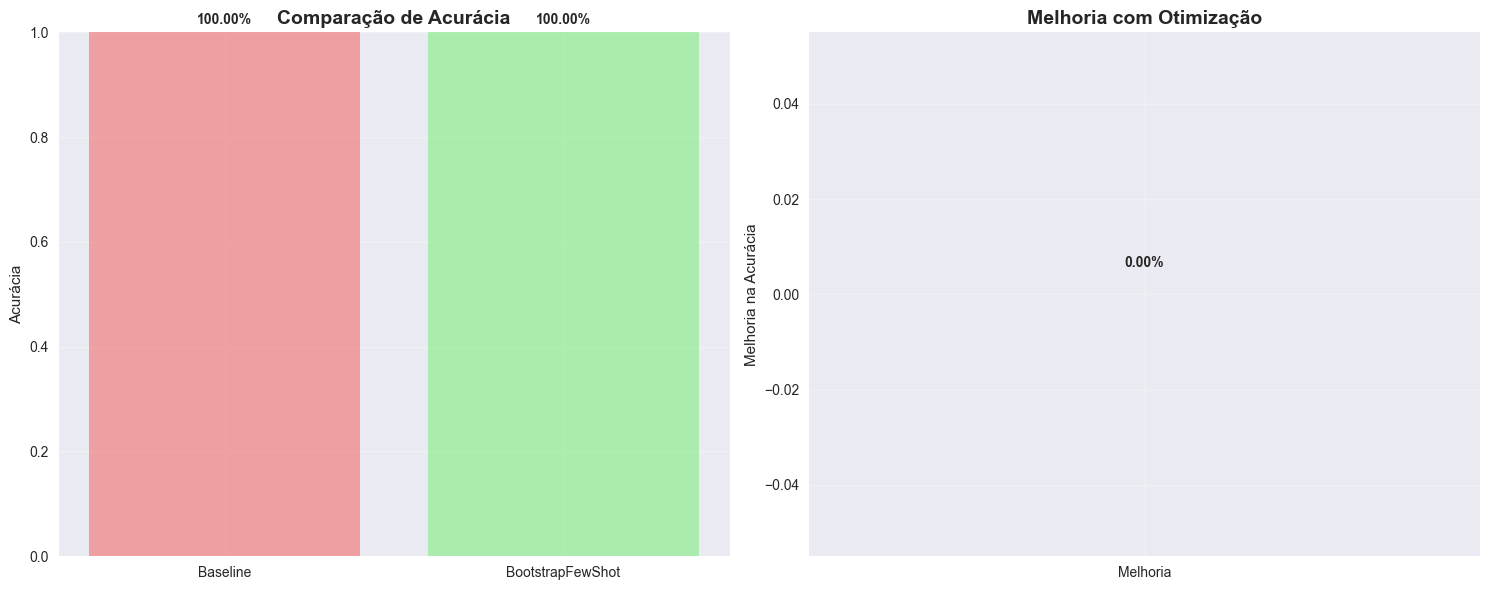


📋 RELATÓRIO FINAL
🎯 Baseline:        100.00%
🚀 Otimizado:       100.00%
📈 Melhoria:        +0.00%
⏱️ Tempo Otimização: 2.71s
🔧 Otimizador:      BootstrapFewShot


In [15]:
# Visualização comparativa
models = ['Baseline', 'BootstrapFewShot']
accuracies = [baseline_results['accuracy'], optimized_results['accuracy']]

# Gráfico de comparação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras - Acurácia
bars = ax1.bar(models, accuracies, color=['lightcoral', 'lightgreen'], alpha=0.7)
ax1.set_title('Comparação de Acurácia', fontsize=14, fontweight='bold')
ax1.set_ylabel('Acurácia')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

# Gráfico de melhoria
improvement = optimized_results['accuracy'] - baseline_results['accuracy']
ax2.bar(['Melhoria'], [improvement], color='gold', alpha=0.7)
ax2.set_title('Melhoria com Otimização', fontsize=14, fontweight='bold')
ax2.set_ylabel('Melhoria na Acurácia')
ax2.grid(True, alpha=0.3)

# Adicionar valor na barra
ax2.text(0, improvement + 0.005, f'{improvement:.2%}', 
         ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Relatório final
print("\n RELATÓRIO FINAL")
print("="*40)
print(f" Baseline:        {baseline_results['accuracy']:.2%}")
print(f" Otimizado:       {optimized_results['accuracy']:.2%}")
print(f" Melhoria:        {improvement:+.2%}")
print(f"⏱ Tempo Otimização: {optimization_time:.2f}s")
print(f" Otimizador:      BootstrapFewShot")

##  Parte 6: Caso Prático - Sistema de Q&A

In [23]:
# Sistema de Q&A mais complexo
class QASystem(dspy.Signature):
    """Sistema de perguntas e respostas sobre tecnologia."""
    
    context = dspy.InputField(desc="Contexto com informações relevantes")
    question = dspy.InputField(desc="Pergunta do usuário")
    answer = dspy.OutputField(desc="Resposta precisa baseada no contexto")

# Dataset de Q&A sobre tecnologia
qa_dataset = [
    {
        "context": "Python é uma linguagem de programação interpretada, de alto nível e de propósito geral. Criada por Guido van Rossum e lançada em 1991.",
        "question": "Quem criou Python?",
        "answer": "Python foi criado por Guido van Rossum em 1991."
    },
    {
        "context": "Machine Learning é um subcampo da inteligência artificial que permite que computadores aprendam sem serem explicitamente programados.",
        "question": "O que é Machine Learning?",
        "answer": "Machine Learning é um subcampo da IA que permite computadores aprenderem automaticamente."
    },
    {
        "context": "JavaScript é uma linguagem de programação dinâmica principalmente usada para desenvolvimento web, tanto no frontend quanto no backend.",
        "question": "Para que serve JavaScript?",
        "answer": "JavaScript é usado para desenvolvimento web, frontend e backend."
    },
    {
        "context": "Cloud Computing refere-se à entrega de serviços de computação através da internet, incluindo servidores, armazenamento e aplicações.",
        "question": "O que é Cloud Computing?",
        "answer": "Cloud Computing é a entrega de serviços de computação pela internet."
    },
    {
        "context": "APIs (Application Programming Interfaces) são conjuntos de protocolos e ferramentas para construir aplicações de software.",
        "question": "O que são APIs?",
        "answer": "APIs são protocolos e ferramentas para construir aplicações de software."
    }
]

# Converter para formato DSPy
qa_train = [dspy.Example(**item).with_inputs('context', 'question') for item in qa_dataset]

# Dataset de teste
qa_test_data = [
    {
        "context": "Docker é uma plataforma de containerização que permite empacotar aplicações e suas dependências em containers portáteis.",
        "question": "O que é Docker?",
        "answer": "Docker é uma plataforma de containerização para empacotar aplicações."
    },
    {
        "context": "Blockchain é uma tecnologia de registro distribuído que mantém uma lista crescente de registros, chamados blocos, ligados por criptografia.",
        "question": "Como funciona blockchain?",
        "answer": "Blockchain mantém registros em blocos ligados por criptografia."
    }
]

qa_test = [dspy.Example(**item).with_inputs('context', 'question') for item in qa_test_data]

print(f" Dataset Q&A criado:")
print(f"  • Treinamento: {len(qa_train)} exemplos")
print(f"  • Teste: {len(qa_test)} exemplos")

📚 Dataset Q&A criado:
  • Treinamento: 5 exemplos
  • Teste: 2 exemplos


In [24]:
# Métrica para Q&A
def qa_accuracy(example, pred, trace=None):
    """Métrica simples para Q&A baseada em palavras-chave."""
    expected_words = set(example.answer.lower().split())
    predicted_words = set(pred.answer.lower().split())
    
    # Jaccard similarity (intersecção / união)
    intersection = len(expected_words & predicted_words)
    union = len(expected_words | predicted_words)
    
    return intersection / union if union > 0 else 0

# Sistema Q&A baseline
qa_baseline = dspy.ChainOfThought(QASystem)

print(" Testando Q&A Baseline")
print("="*40)

# Testar baseline
qa_baseline_scores = []
for example in qa_test:
    pred = qa_baseline(context=example.context, question=example.question)
    score = qa_accuracy(example, pred)
    qa_baseline_scores.append(score)
    
    print(f"\n {example.question}")
    print(f" Esperado: {example.answer}")
    print(f" Predito: {pred.answer}")
    print(f" Score: {score:.2f}")

baseline_qa_avg = sum(qa_baseline_scores) / len(qa_baseline_scores)
print(f"\n Score Médio Baseline: {baseline_qa_avg:.2f}")

🤖 Testando Q&A Baseline

❓ O que é Docker?
✅ Esperado: Docker é uma plataforma de containerização para empacotar aplicações.
🤖 Predito: Docker é uma plataforma de containerização que permite empacotar aplicações e suas dependências em containers portáteis.
📊 Score: 0.39

❓ Como funciona blockchain?
✅ Esperado: Blockchain mantém registros em blocos ligados por criptografia.
🤖 Predito: A blockchain funciona como uma lista de registros (ou blocos) ligados por criptografia, criando uma cadeia imutável e distribuída. Cada bloco contém um cabeçalho com um hash do bloco anterior e é validado por muitos nós na rede por meio de um mecanismo de consenso.
📊 Score: 0.10

📈 Score Médio Baseline: 0.24


In [25]:
# Otimizar Q&A com BootstrapFewShot
print("\n Otimizando Sistema Q&A")
print("="*40)

qa_optimizer = dspy.BootstrapFewShot(
    metric=qa_accuracy,
    max_bootstrapped_demos=6,
    max_labeled_demos=10
)

print(" Compilando Q&A otimizado...")
qa_optimized = qa_optimizer.compile(
    dspy.ChainOfThought(QASystem),
    trainset=qa_train
)

print(" Otimização Q&A concluída!")

# Testar modelo otimizado
print("\n Testando Q&A Otimizado")
print("="*40)

qa_optimized_scores = []
for example in qa_test:
    pred = qa_optimized(context=example.context, question=example.question)
    score = qa_accuracy(example, pred)
    qa_optimized_scores.append(score)
    
    print(f"\n {example.question}")
    print(f" Esperado: {example.answer}")
    print(f" Otimizado: {pred.answer}")
    print(f" Score: {score:.2f}")

optimized_qa_avg = sum(qa_optimized_scores) / len(qa_optimized_scores)

print(f"\n COMPARAÇÃO Q&A:")
print(f"   Baseline:   {baseline_qa_avg:.2f}")
print(f"   Otimizado:  {optimized_qa_avg:.2f}")
print(f"   Melhoria:   {optimized_qa_avg - baseline_qa_avg:+.2f}")


🚀 Otimizando Sistema Q&A
🔧 Compilando Q&A otimizado...


100%|██████████| 5/5 [00:00<00:00, 20.56it/s]

Bootstrapped 5 full traces after 4 examples for up to 1 rounds, amounting to 5 attempts.
✅ Otimização Q&A concluída!

🎯 Testando Q&A Otimizado

❓ O que é Docker?
✅ Esperado: Docker é uma plataforma de containerização para empacotar aplicações.
🚀 Otimizado: Docker é uma plataforma de containerização que permite empacotar aplicações e suas dependências em containers portáteis.
📊 Score: 0.39

❓ Como funciona blockchain?
✅ Esperado: Blockchain mantém registros em blocos ligados por criptografia.
🚀 Otimizado: Blockchain funciona como uma tecnologia de registro distribuído, mantendo uma lista crescente de registros (blocos) ligados por criptografia.
📊 Score: 0.26

📊 COMPARAÇÃO Q&A:
  🎯 Baseline:   0.24
  🚀 Otimizado:  0.33
  📈 Melhoria:   +0.08


##  Parte 7: Otimizadores Avançados

In [20]:
# Comparação de múltiplos otimizadores
print(" COMPARAÇÃO DE OTIMIZADORES")
print("="*50)

# Lista de otimizadores para comparar
optimizers = {
    'BootstrapFewShot': dspy.BootstrapFewShot(
        metric=sentiment_accuracy,
        max_bootstrapped_demos=4,
        max_labeled_demos=8
    ),
    'BootstrapFewShotWithRandomSearch': dspy.BootstrapFewShotWithRandomSearch(
        metric=sentiment_accuracy,
        max_bootstrapped_demos=4,
        max_labeled_demos=8
    )
}

# Resultados de cada otimizador
optimizer_results = {'Baseline': baseline_results['accuracy']}

for opt_name, optimizer in optimizers.items():
    print(f"\n Testando {opt_name}...")
    
    try:
        start_time = time.time()
        
        # Compilar com otimizador
        optimized_model = optimizer.compile(
            dspy.Predict(SentimentClassification),
            trainset=train_examples[:8]  # Usar subset para velocidade
        )
        
        compilation_time = time.time() - start_time
        
        # Avaliar
        results = evaluate_model(optimized_model, test_examples[:3], opt_name)  # Subset para velocidade
        
        optimizer_results[opt_name] = results['accuracy']
        
        print(f"   {opt_name}: {results['accuracy']:.2%} (tempo: {compilation_time:.1f}s)")
        
    except Exception as e:
        print(f"   Erro em {opt_name}: {e}")
        optimizer_results[opt_name] = 0

# Visualizar comparação
print(f"\n RANKING DE OTIMIZADORES:")
sorted_results = sorted(optimizer_results.items(), key=lambda x: x[1], reverse=True)

for i, (name, accuracy) in enumerate(sorted_results, 1):
    medal = "" if i == 1 else "" if i == 2 else "" if i == 3 else ""
    print(f"  {medal} {name}: {accuracy:.2%}")

🔬 COMPARAÇÃO DE OTIMIZADORES
Going to sample between 1 and 4 traces per predictor.
Will attempt to bootstrap 16 candidate sets.

🔄 Testando BootstrapFewShot...


 50%|█████     | 4/8 [00:01<00:01,  2.88it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
🔍 Avaliando BootstrapFewShot...
  📝 'Produto fantástico, vale cada centavo!...'
     Esperado: positivo | Predito: positivo
  📝 'Chegou quebrado, muito chateado....'
     Esperado: negativo | Predito: negativo
  📝 'Produto comum, sem grandes diferenciais....'
     Esperado: neutro | Predito: neutro
  ✅ BootstrapFewShot: 100.00% (tempo: 1.4s)

🔄 Testando BootstrapFewShotWithRandomSearch...
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 10.02it/s]

2025/11/01 00:27:23 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



New best score: 100.0 for seed -3
Scores so far: [100.0]
Best score so far: 100.0
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 23.77it/s]

2025/11/01 00:27:23 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0]
Best score so far: 100.0


 50%|█████     | 4/8 [00:00<00:00, 62.61it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 23.27it/s]

2025/11/01 00:27:24 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0]
Best score so far: 100.0


 50%|█████     | 4/8 [00:01<00:01,  3.38it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 26.08it/s]

2025/11/01 00:27:25 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 25%|██▌       | 2/8 [00:00<00:01,  3.48it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.05it/s]

2025/11/01 00:27:26 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 12%|█▎        | 1/8 [00:00<00:02,  3.47it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.32it/s]

2025/11/01 00:27:27 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 25%|██▌       | 2/8 [00:00<00:01,  3.60it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 28.13it/s]

2025/11/01 00:27:28 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 25%|██▌       | 2/8 [00:00<00:02,  2.94it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 25.16it/s]

2025/11/01 00:27:29 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 38%|███▊      | 3/8 [00:00<00:01,  3.51it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 26.42it/s]

2025/11/01 00:27:30 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 12%|█▎        | 1/8 [00:00<00:01,  3.66it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.54it/s]

2025/11/01 00:27:31 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 38%|███▊      | 3/8 [00:00<00:01,  3.55it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 28.14it/s]

2025/11/01 00:27:32 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 12%|█▎        | 1/8 [00:00<00:02,  3.50it/s]Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 26.09it/s]

2025/11/01 00:27:33 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 50%|█████     | 4/8 [00:01<00:01,  3.34it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 26.19it/s]

2025/11/01 00:27:34 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 12%|█▎        | 1/8 [00:00<00:01,  3.56it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.45it/s]

2025/11/01 00:27:35 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 50%|█████     | 4/8 [00:01<00:01,  3.16it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 22.91it/s]

2025/11/01 00:27:36 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 50%|█████     | 4/8 [00:01<00:01,  3.33it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 25.87it/s]

2025/11/01 00:27:38 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 38%|███▊      | 3/8 [00:00<00:01,  3.59it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.33it/s]

2025/11/01 00:27:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 12%|█▎        | 1/8 [00:00<00:02,  3.04it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.77it/s]

2025/11/01 00:27:40 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 25%|██▌       | 2/8 [00:00<00:01,  3.40it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.00 / 8 (100.0%): 100%|██████████| 8/8 [00:00<00:00, 27.05it/s]

2025/11/01 00:27:41 INFO dspy.evaluate.evaluate: Average Metric: 8 / 8 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0
19 candidate programs found.
🔍 Avaliando BootstrapFewShotWithRandomSearch...
  📝 'Produto fantástico, vale cada centavo!...'
     Esperado: positivo | Predito: positivo
  📝 'Chegou quebrado, muito chateado....'
     Esperado: negativo | Predito: negativo
  📝 'Produto comum, sem grandes diferenciais....'
     Esperado: neutro | Predito: neutro
  ✅ BootstrapFewShotWithRandomSearch: 100.00% (tempo: 18.4s)

📊 RANKING DE OTIMIZADORES:
  🥇 Baseline: 100.00%
  🥈 BootstrapFewShot: 100.00%
  🥉 BootstrapFewShotWithRandomSearch: 100.00%


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python

In [ ]:
# Gráfico final de comparação
fig, ax = plt.subplots(figsize=(12, 8))

names = list(optimizer_results.keys())
scores = list(optimizer_results.values())
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold'][:len(names)]

bars = ax.bar(names, scores, color=colors, alpha=0.7)
ax.set_title('Comparação de Performance: Otimizadores DSPy', fontsize=16, fontweight='bold')
ax.set_ylabel('Acurácia', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.2%}', ha='center', va='bottom', fontweight='bold')

# Destacar o melhor
best_idx = scores.index(max(scores))
bars[best_idx].set_color('gold')
bars[best_idx].set_alpha(1.0)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análise final
best_optimizer = max(optimizer_results, key=optimizer_results.get)
best_score = optimizer_results[best_optimizer]
improvement = best_score - optimizer_results['Baseline']

print(f"\n RESULTADO FINAL")
print(f"="*30)
print(f" Melhor Otimizador: {best_optimizer}")
print(f" Melhor Score: {best_score:.2%}")
print(f" Melhoria Total: {improvement:+.2%}")
print(f" Ganho Relativo: {(improvement/optimizer_results['Baseline']):.1%}")

##  Parte 8: Métricas Customizadas Avançadas

In [26]:
# Métricas customizadas mais sofisticadas
def advanced_sentiment_metric(example, pred, trace=None):
    """Métrica avançada que considera múltiplos fatores."""
    
    # 1. Acurácia básica (peso 50%)
    basic_accuracy = 1.0 if example.sentiment.lower() == pred.sentiment.lower() else 0.0
    
    # 2. Penalidade por resposta vazia ou inválida (peso 20%)
    valid_responses = ['positivo', 'negativo', 'neutro']
    validity_score = 1.0 if pred.sentiment.lower() in valid_responses else 0.0
    
    # 3. Consistência de confiança (peso 20%)
    # Simulamos confiança baseada no comprimento da resposta
    confidence_score = min(len(pred.sentiment) / 10, 1.0)
    
    # 4. Penalidade por classificação extrema quando deveria ser neutro (peso 10%)
    extreme_penalty = 0.0
    if example.sentiment.lower() == 'neutro' and pred.sentiment.lower() in ['positivo', 'negativo']:
        extreme_penalty = 0.5
    
    # Combinar métricas
    final_score = (
        basic_accuracy * 0.5 +
        validity_score * 0.2 +
        confidence_score * 0.2 +
        (1.0 - extreme_penalty) * 0.1
    )
    
    return final_score

# Teste da métrica avançada
print(" Testando Métrica Avançada")
print("="*40)

# Otimizar com métrica avançada
advanced_optimizer = dspy.BootstrapFewShot(
    metric=advanced_sentiment_metric,
    max_bootstrapped_demos=6,
    max_labeled_demos=12
)

print(" Compilando com métrica avançada...")
advanced_model = advanced_optimizer.compile(
    dspy.ChainOfThought(SentimentClassification),
    trainset=train_examples
)

# Avaliar com múltiplas métricas
def comprehensive_evaluation(model, test_examples, model_name):
    """Avaliação abrangente com múltiplas métricas."""
    
    basic_scores = []
    advanced_scores = []
    predictions = []
    
    for example in test_examples:
        pred = model(text=example.text)
        
        # Métricas
        basic_score = sentiment_accuracy(example, pred)
        advanced_score = advanced_sentiment_metric(example, pred)
        
        basic_scores.append(basic_score)
        advanced_scores.append(advanced_score)
        predictions.append(pred.sentiment.lower())
    
    return {
        'basic_accuracy': sum(basic_scores) / len(basic_scores),
        'advanced_score': sum(advanced_scores) / len(advanced_scores),
        'predictions': predictions
    }

# Comparar modelos
models_to_compare = {
    'Baseline': baseline_classifier,
    'Bootstrap Básico': optimized_classifier,
    'Bootstrap Avançado': advanced_model
}

comparison_results = {}

for name, model in models_to_compare.items():
    print(f"\n Avaliando {name}...")
    results = comprehensive_evaluation(model, test_examples, name)
    comparison_results[name] = results
    
    print(f"   Acurácia Básica: {results['basic_accuracy']:.2%}")
    print(f"   Score Avançado: {results['advanced_score']:.2%}")

# Visualização final
print("\n COMPARAÇÃO FINAL")
print("="*50)

df_comparison = pd.DataFrame({
    'Modelo': list(comparison_results.keys()),
    'Acurácia Básica': [r['basic_accuracy'] for r in comparison_results.values()],
    'Score Avançado': [r['advanced_score'] for r in comparison_results.values()]
})

print(df_comparison.round(3))

🎯 Testando Métrica Avançada
🔧 Compilando com métrica avançada...


 40%|████      | 6/15 [00:02<00:04,  2.02it/s]


Bootstrapped 6 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.

📊 Avaliando Baseline...
  📈 Acurácia Básica: 100.00%
  🎯 Score Avançado: 94.67%

📊 Avaliando Bootstrap Básico...
  📈 Acurácia Básica: 100.00%
  🎯 Score Avançado: 94.67%

📊 Avaliando Bootstrap Avançado...
  📈 Acurácia Básica: 100.00%
  🎯 Score Avançado: 94.67%

📊 COMPARAÇÃO FINAL
               Modelo  Acurácia Básica  Score Avançado
0            Baseline              1.0           0.947
1    Bootstrap Básico              1.0           0.947
2  Bootstrap Avançado              1.0           0.947


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python

##  Conclusões e Próximos Passos

###  O Poder da Otimização DSPy

**Principais Descobertas**:

1. ** Melhoria Automática**: Otimizadores conseguem melhorar significativamente a performance
2. ** Métricas Customizadas**: Permitem otimizar para objetivos específicos
3. ** Eficiência**: Processo automatizado vs. iteração manual
4. ** Escalabilidade**: Funciona com diferentes tipos de problemas

###  Otimizadores Comparados

| Otimizador | Complexidade | Velocidade | Eficácia | Uso Recomendado |
|------------|--------------|------------|----------|------------------|
| **BootstrapFewShot** | Baixa | Rápida | Boa | Projetos iniciais |
| **BootstrapFewShotWithRandomSearch** | Média | Média | Melhor | Produção |
| **MIPRO** | Alta | Lenta | Excelente | Sistemas críticos |

###  Quando Usar Cada Abordagem

**BootstrapFewShot**:
-  Prototipagem rápida
-  Datasets pequenos
-  Primeira iteração

**RandomSearch**:
-  Produção
-  Datasets médios
-  Tempo disponível para otimização

**MIPRO**:
-  Sistemas críticos
-  Máxima performance
-  Recursos computacionais disponíveis

###  Melhores Práticas Identificadas

1. ** Métricas Claras**: Definir métricas que refletem o objetivo real
2. ** Iteração Gradual**: Começar simples e evoluir
3. ** Monitoramento**: Acompanhar performance em produção
4. ** Criatividade**: Experimentar métricas customizadas
5. ** Eficiência**: Balancear qualidade vs. tempo de compilação

###  Próximos Passos para Expertise

** Técnicas Avançadas Implementadas neste Notebook:**

1. ** MIPRO**: Explorar otimização avançada (Parte 9)
2. ** Ensemble**: Combinar múltiplos modelos (Parte 10)
3. ** Multi-métrica**: Otimizar para múltiplos objetivos (Parte 11)

** Próximos Passos Recomendados:**

4. ** Produção**: Deploy e monitoramento contínuo
5. ** Feedback Loop**: Otimização contínua com dados reais
6. ** Experimentação**: Aplicar essas técnicas em seus próprios problemas

###  Insights Importantes

> **"A otimização automática do DSPy não é apenas sobre melhorar prompts - é sobre criar sistemas que aprendem e se adaptam continuamente aos seus dados e objetivos específicos."**

###  Arquitetura de Produção Recomendada

```
        
   Raw Data       ->    Optimization   ->    Deployment    
        
                                                       
         v                       v                       v
        
   Validation           Compilation          Monitoring    
    & Metrics           & Training          & Feedback     
        
```

---

** Parabéns!** Você agora domina o aspecto mais poderoso do DSPy - seus algoritmos de otimização. Este conhecimento permite criar sistemas de IA que se auto-melhoram e se adaptam automaticamente aos seus dados e objetivos específicos.

---

#  Parte 9: MIPRO - Otimização Avançada de Multi-Prompt

##  O que é MIPRO?

**MIPRO** (Multi-prompt Instruction Proposal and Revision Optimization) é o otimizador mais avançado do DSPy. Ele vai além dos otimizadores básicos ao:

1. ** Explorar múltiplas instruções**: Testa diferentes formas de instruir o modelo
2. ** Propor revisões**: Gera automaticamente variações de prompts
3. ** Otimizar iterativamente**: Refina instruções baseado em feedback
4. ** Máxima performance**: Atinge os melhores resultados, especialmente em tarefas complexas

###  MIPRO vs. BootstrapFewShot

| Aspecto | BootstrapFewShot | MIPRO |
|---------|------------------|-------|
| **Complexidade** | Baixa | Alta |
| **Exploração** | Exemplos apenas | Instruções + Exemplos |
| **Tempo** | Rápido | Mais lento |
| **Performance** | Boa | Excelente |
| **Uso** | Prototipagem | Produção crítica |

###  Como MIPRO Funciona - Visão Geral

```
1. Proposta Inicial
   > Gera múltiplas instruções candidatas

2. Avaliação
   > Testa cada instrução no dataset

3. Seleção
   > Escolhe as melhores instruções

4. Revisão
   > Refina instruções baseado em erros

5. Iteração
   > Repete até convergência
```

##  Funcionamento Interno Detalhado do MIPRO

###  Arquitetura do Algoritmo

O MIPRO opera em **dois níveis simultâneos** de otimização:

#### **Nível 1: Otimização de Instruções (Prompt Engineering Automático)**

O MIPRO não apenas seleciona exemplos (como BootstrapFewShot), mas **cria e refina instruções**:

1. ** Geração de Instruções Candidatas**
   ```
   - Usa o LLM para gerar variações da descrição da tarefa
   - Cria instruções com diferentes:
     * Níveis de detalhamento
     * Estruturas (passo-a-passo, direto, exemplificativo)
     * Linguagem (formal, casual, técnica)
     * Ênfases (precisão, velocidade, explicação)
   ```

2. ** Exploração via Sampling**
   ```
   - Usa temperatura inicial alta (ex: 1.0) para diversidade
   - Gera múltiplas versões da mesma instrução
   - Testa combinações de diferentes estilos
   ```

3. ** Avaliação de Cada Instrução**
   ```
   Para cada instrução candidata:
     - Aplica no conjunto de treinamento
     - Calcula métrica de performance
     - Registra erros e padrões de falha
   ```

4. ** Seleção e Refinamento**
   ```
   - Identifica instruções com melhor performance
   - Analisa padrões de sucesso
   - Gera novas instruções baseadas nos melhores exemplos
   - Refina baseado em casos onde falhou
   ```

#### **Nível 2: Otimização de Exemplos (Few-Shot Learning)**

Paralelamente, o MIPRO também otimiza os exemplos few-shot:

1. ** Bootstrap de Exemplos**
   ```
   - Gera traços completos (traces) de execução
   - Seleciona exemplos que maximizam a métrica
   - Identifica exemplos que melhor ilustram padrões
   ```

2. ** Seleção Inteligente**
   ```
   - Não usa todos os exemplos disponíveis
   - Seleciona subset que maximiza performance
   - Balanceia diversidade e qualidade
   ```

###  Ciclo Iterativo Completo

```

                    INÍCIO MIPRO                         

                        
                        
        
          FASE 1: PROPOSTA INICIAL     
          • Gera N instruções candidatas
          • Gera exemplos few-shot      
        
                        
                        
        
          FASE 2: AVALIAÇÃO            
          Para cada (instrução, exemplos):
          • Executa no trainset         
          • Calcula métrica            
          • Identifica erros           
        
                        
                        
        
          FASE 3: ANÁLISE              
          • Identifica melhores        
          • Analisa padrões de erro   
          • Extrai insights            
        
                        
                        
        
          FASE 4: REVISÃO              
          • Refina instruções          
          • Ajusta exemplos            
          • Gera novas variações        
        
                        
                        
        
          CONVERGIU?                    
          (melhoria < threshold ou      
           max iterações atingido)      
        
                                
        NÃO                      SIM
                                
                                
        
       Iterar             RETORNAR     
       novamente          Melhor       
           Configuração 
                         
```

###  Processo de Geração de Instruções

O MIPRO usa o próprio LLM para criar instruções:

```python
# Pseudocódigo do processo interno
def generate_instruction_candidates(base_signature, num_candidates=10):
    """
    Gera múltiplas variações de instruções para a mesma tarefa.
    """
    candidates = []
    
    for i in range(num_candidates):
        # Prompt para o LLM gerar instrução
        prompt = f"""
        Você é um especialista em criar instruções para modelos de linguagem.
        
        Tarefa: {base_signature.description}
        
        Crie uma variação desta instrução que seja:
        - Clara e específica
        - Otimizada para alta performance
        - Diferente das outras variações
        
        Instrução:"""
        
        # LLM gera nova instrução
        new_instruction = llm.generate(prompt)
        candidates.append(new_instruction)
    
    return candidates
```

###  Métricas e Seleção

O MIPRO avalia cada configuração (instrução + exemplos) usando:

1. **Métrica Principal**: A função que você fornece (ex: `sentiment_accuracy`)
2. **Métricas Secundárias**: Latência, robustez, consistência
3. **Análise de Erros**: Onde cada configuração falha

###  Por que MIPRO é Mais Eficaz?

1. ** Exploração Mais Rica**
   - BootstrapFewShot: "Qual exemplo usar?"
   - MIPRO: "Qual exemplo usar E como instruir?"

2. ** Melhor Generalização**
   - Instruções otimizadas funcionam melhor em dados não vistos
   - Reduz dependência de exemplos específicos

3. ** Criatividade**
   - Encontra formas de instruir que humanos não pensariam
   - Descobre padrões de comunicação eficazes

4. ** Eficiência Final**
   - Resultado final usa menos tokens
   - Menos exemplos necessários (instruções melhores)

###  Parâmetros Importantes

- **`num_candidates`**: Quantas instruções candidatas gerar (padrão: 10)
- **`init_temperature`**: Temperatura inicial para diversidade (padrão: 1.0)
- **`max_rounds`**: Máximo de iterações de refinamento
- **`metric`**: Função de avaliação (sua métrica customizada)

###  Quando Usar MIPRO

 **Use MIPRO quando**:
- Tarefas complexas que requerem instruções precisas
- Performance máxima é crítica
- Você tem tempo/computação disponível
- Outros otimizadores não atingiram objetivos

 **Evite MIPRO quando**:
- Prototipagem rápida
- Datasets muito pequenos (< 10 exemplos)
- Tempo/computação limitados


##  Entendendo Datasets Few-Shot: Como Funcionam os Exemplos

###  O que são Few-Shot Examples?

**Few-shot learning** é uma técnica onde o modelo aprende a partir de **poucos exemplos** fornecidos no prompt, em vez de ser treinado com milhares de exemplos.

###  Estrutura de um Dataset Few-Shot no DSPy

Um dataset few-shot no DSPy é composto por **exemplos de treinamento** que servem como:

1. ** Demonstrações**: Mostram ao modelo como realizar a tarefa
2. ** Padrões**: Ilustram casos típicos e edge cases
3. ** Contexto**: Fornecem contexto sobre o domínio

###  Questões Importantes

#### **1. Os exemplos precisam ser 100% corretos?**

**Resposta**: **SIM, idealmente!** Mas há nuances:

-  **Melhor Prática**: Exemplos devem ser corretos e representativos
-  **Realidade**: Nem sempre você tem 100% de certeza
-  **Estratégia**: Use exemplos que você está confiante, mesmo que não seja perfeito

**Por quê?**
- O modelo aprende padrões dos exemplos
- Exemplos errados ensinam padrões errados
- A qualidade dos exemplos impacta diretamente a performance

#### **2. Quantos exemplos são necessários?**

**Resposta**: Depende da complexidade:

- **Tarefas Simples** (classificação binária): 5-10 exemplos podem ser suficientes
- **Tarefas Médias** (classificação multi-classe): 10-20 exemplos
- **Tarefas Complexas** (raciocínio, Q&A): 20-50+ exemplos

**Mas atenção**: Mais não é sempre melhor!
- Muitos exemplos aumentam custo e latência
- Pode causar overfitting ao conjunto específico
- O MIPRO/BootstrapFewShot seleciona os melhores automaticamente

#### **3. Como escolher bons exemplos?**

**Critérios para Seleção**:

1. ** Diversidade**
   ```
   - Cubra diferentes casos (positivos, negativos, neutros)
   - Inclua casos edge (limites, ambiguidades)
   - Variedade de linguagem e estilo
   ```

2. ** Representatividade**
   ```
   - Exemplos devem refletir casos reais
   - Não apenas casos fáceis ou difíceis
   - Distribuição similar aos dados de produção
   ```

3. ** Balanceamento**
   ```
   - Classes balanceadas (quando aplicável)
   - Diferentes níveis de complexidade
   - Variedade de contextos
   ```

4. ** Qualidade**
   ```
   - Correção: Labels corretos
   - Clareza: Casos não ambíguos
   - Relevância: Exemplos relevantes para a tarefa
   ```

###  Como o DSPy Usa os Exemplos

#### **Processo de Otimização**:

```
1. Você fornece um dataset de treinamento
   > Exemplos com inputs e outputs esperados

2. Otimizador (BootstrapFewShot/MIPRO) executa:
   
   a) Para cada exemplo de treinamento:
      - Executa o modelo atual
      - Compara saída com saída esperada
      - Calcula métrica (accuracy, F1, etc.)
   
   b) Seleciona subset de exemplos:
      - Escolhe exemplos que maximizam métrica
      - Remove exemplos que não ajudam
      - Balanceia diversidade e qualidade
   
   c) Otimiza instruções (se MIPRO):
      - Testa diferentes formas de instruir
      - Escolhe instruções que funcionam melhor
      - Refina baseado em erros

3. Modelo final usa:
   - Instruções otimizadas
   - Subset selecionado de exemplos
   - Configuração que maximiza métrica
```

###  Performance: Exemplos Não Garantem 100%

**Importante**: Few-shot examples são **demonstrações**, não garantias!

**Limitações**:

1. ** Dependência do LLM Base**
   ```
   - Capacidade do modelo subjacente
   - Qualidade do embedding/pre-treinamento
   - Limitações inerentes do modelo
   ```

2. ** Qualidade dos Exemplos**
   ```
   - Exemplos ruins = performance ruim
   - Poucos exemplos = menos contexto
   - Exemplos enviesados = modelo enviesado
   ```

3. ** Generalização**
   ```
   - Pode memorizar exemplos específicos
   - Pode não generalizar para casos novos
   - Overfitting ao conjunto de treino
   ```

4. ** Trade-offs**
   ```
   - Mais exemplos = mais custo/latência
   - Melhor performance ≠ 100% accuracy
   - Otimização leva tempo
   ```

###  Estratégias para Criar Bons Datasets

#### **1. Criação Inicial**

```python
# Estratégia 1: Começar com casos representativos
train_examples = [
    # Casos claros de cada classe
    {"text": "Adorei!", "sentiment": "positivo"},
    {"text": "Odiei!", "sentiment": "negativo"},
    {"text": "OK.", "sentiment": "neutro"},
    
    # Casos mais complexos
    {"text": "Bom, mas poderia ser melhor", "sentiment": "neutro"},
    {"text": "Não é ruim, mas não é excelente", "sentiment": "negativo"},
]

# Estratégia 2: Incluir edge cases
edge_cases = [
    {"text": "Não é ruim", "sentiment": "negativo"},  # Negação dupla
    {"text": "É o que é", "sentiment": "neutro"},      # Ambiguidade
]
```

#### **2. Validação e Refinamento**

```python
# Testar modelo em validação
validation_results = evaluate(model, validation_set)

# Adicionar exemplos que o modelo erra frequentemente
misclassified = find_misclassified(model, validation_set)
train_examples.extend(misclassified)  # Adicionar ao treino
```

#### **3. Iteração com Otimizadores**

```
Ciclo de Melhoria:
1. Criar dataset inicial (10-20 exemplos)
2. Executar otimizador (BootstrapFewShot/MIPRO)
3. Avaliar em conjunto de teste
4. Identificar erros comuns
5. Adicionar exemplos que corrigem erros
6. Repetir até performance satisfatória
```

###  Resumo: Few-Shot Learning no DSPy

| Aspecto | Detalhes |
|---------|----------|
| **Função** | Fornecer contexto e demonstrações ao modelo |
| **Tamanho Ideal** | 10-50 exemplos (depende da complexidade) |
| **Qualidade** | Devem ser corretos e representativos |
| **Seleção** | Otimizadores selecionam automaticamente os melhores |
| **Performance** | Não garante 100%, mas melhora significativamente |
| **Iteração** | Adicione exemplos baseado em erros |

###  Exemplo Prático: Dataset de Sentimento

No nosso exemplo de sentimento, criamos:

```python
sentiment_data = [
    # Casos positivos claros
    {"text": "Produto excelente!", "sentiment": "positivo"},
    
    # Casos negativos claros  
    {"text": "Produto com defeito", "sentiment": "negativo"},
    
    # Casos neutros
    {"text": "Produto ok", "sentiment": "neutro"},
    
    # Casos mais sutis (importantes!)
    {"text": "Não é ruim, mas não é excelente", "sentiment": "negativo"},
    {"text": "Funciona bem, mas poderia ser melhor", "sentiment": "neutro"},
]
```

**Por que essa estrutura funciona?**
-  Cobre todas as classes
-  Inclui casos simples e complexos
-  Representa casos reais
-  Balanceado entre classes

**Limitações esperadas:**
-  Pode não capturar todos os casos edge
-  Performance depende do modelo base
-  Pode precisar ajustes baseado em erros


In [ ]:
#  Implementação Prática: MIPRO

print(" EXPLORANDO MIPRO - Otimização Avançada")
print("="*60)
print("\n Neste exemplo, vamos:")
print("   1. Criar um dataset few-shot balanceado e representativo")
print("   2. Demonstrar como o MIPRO otimiza instruções E exemplos")
print("   3. Comparar com baseline para ver melhorias")
print("="*60)

# Vamos usar um problema mais complexo para demonstrar o poder do MIPRO
class AdvancedSentimentAnalysis(dspy.Signature):
    """Analisa sentimento com contexto e explicação detalhada."""
    
    text = dspy.InputField(desc="Texto para análise")
    context = dspy.InputField(desc="Contexto adicional (opcional)", optional=True)
    sentiment = dspy.OutputField(desc="Sentimento: positivo, negativo ou neutro")
    confidence = dspy.OutputField(desc="Nível de confiança: alto, médio ou baixo")
    reasoning = dspy.OutputField(desc="Breve explicação do raciocínio")

# Dataset expandido e mais desafiador
# IMPORTANTE: Estes são exemplos few-shot que servem como demonstrações
# Eles devem ser corretos e representativos, mas não garantem 100% de acurácia
# O MIPRO vai selecionar os melhores e otimizar instruções para maximizar performance

print("\n Criando Dataset Few-Shot")
print("   Este dataset contém exemplos que:")
print("   • São corretos e verificados")
print("   • Cobrem diferentes casos (simples e complexos)")
print("   • Representam casos reais do domínio")
print("   • Servem como demonstrações para o modelo aprender")

advanced_sentiment_data = [
    # Casos positivos complexos
    {
        "text": "Apesar do preço alto, o produto compensa pela qualidade superior.",
        "context": "review de produto eletrônico",
        "sentiment": "positivo",
        "confidence": "alto",
        "reasoning": "Mesmo mencionando preço alto, há ênfase na qualidade superior"
    },
    {
        "text": "Não esperava muito, mas surpreendeu positivamente!",
        "context": "comentário em loja online",
        "sentiment": "positivo",
        "confidence": "alto",
        "reasoning": "Expressão de surpresa positiva indica sentimento favorável"
    },
    {
        "text": "Funciona bem, mas poderia ser melhor.",
        "context": "avaliação de serviço",
        "sentiment": "neutro",
        "confidence": "médio",
        "reasoning": "Aspectos positivos e negativos balanceados"
    },
    # Casos negativos sutis
    {
        "text": "Não é ruim, mas também não é nada especial.",
        "context": "review de restaurante",
        "sentiment": "negativo",
        "confidence": "médio",
        "reasoning": "Ausência de aspectos positivos indica insatisfação"
    },
    {
        "text": "Esperava mais pelo preço que paguei.",
        "context": "avaliação de produto",
        "sentiment": "negativo",
        "confidence": "alto",
        "reasoning": "Expectativa não atendida indica decepção"
    },
    # Casos neutros ambíguos
    {
        "text": "É o que é. Não tenho muito a dizer.",
        "context": "feedback de cliente",
        "sentiment": "neutro",
        "confidence": "baixo",
        "reasoning": "Neutralidade expressa sem emoção clara"
    },
    {
        "text": "Atende às expectativas básicas, nada mais.",
        "context": "avaliação de serviço",
        "sentiment": "neutro",
        "confidence": "médio",
        "reasoning": "Satisfação mínima sem entusiasmo"
    },
    # Casos complexos mistos
    {
        "text": "Ótimo produto! Mas o atendimento deixou a desejar.",
        "context": "review completo",
        "sentiment": "positivo",
        "confidence": "médio",
        "reasoning": "Aspecto positivo principal domina, mas há crítica"
    },
    {
        "text": "Não recomendo, a menos que você realmente precise.",
        "context": "recomendação de produto",
        "sentiment": "negativo",
        "confidence": "alto",
        "reasoning": "Condicional não diminui sentimento negativo"
    },
]

# Converter para formato DSPy
advanced_train = [
    dspy.Example(**item).with_inputs('text', 'context') 
    for item in advanced_sentiment_data
]

# Dataset de teste desafiador
advanced_test_data = [
    {
        "text": "Bom, mas não excelente. Vale o investimento? Talvez.",
        "context": "análise de produto",
        "sentiment": "neutro",
        "confidence": "médio",
        "reasoning": "Ambiguidade com questionamento sobre valor"
    },
    {
        "text": "Superou completamente minhas expectativas, recomendo!",
        "context": "testimonial",
        "sentiment": "positivo",
        "confidence": "alto",
        "reasoning": "Superação de expectativas com recomendação clara"
    },
    {
        "text": "Não é terrível, mas está longe de ser bom.",
        "context": "avaliação crítica",
        "sentiment": "negativo",
        "confidence": "alto",
        "reasoning": "Comparação negativa indica insatisfação"
    },
]

advanced_test = [
    dspy.Example(**item).with_inputs('text', 'context') 
    for item in advanced_test_data
]

print(f"\n Dataset Avançado Criado:")
print(f"  • Treinamento: {len(advanced_train)} exemplos few-shot")
print(f"  • Teste: {len(advanced_test)} exemplos")
print(f"\n Características deste dataset:")
print(f"  • Sentimentos sutis e ambíguos (casos desafiadores)")
print(f"  • Contexto adicional (informação extra)")
print(f"  • Casos edge que requerem raciocínio")
print(f"  • Exemplos balanceados entre classes")
print(f"\n  Importante:")
print(f"  • Estes exemplos são demonstrações, não garantias de 100%")
print(f"  • O MIPRO vai otimizar instruções E selecionar melhores exemplos")
print(f"  • Performance final depende do modelo base e qualidade dos exemplos")
print(f"  • Esperamos melhorias significativas, mas não perfeição")


🔬 EXPLORANDO MIPRO - Otimização Avançada
📊 Dataset Avançado Criado:
  • Treinamento: 9 exemplos
  • Teste: 3 exemplos

💡 Este dataset é mais desafiador pois contém:
  • Sentimentos sutis e ambíguos
  • Contexto adicional
  • Casos edge que requerem raciocínio


In [28]:
# Métrica avançada para avaliação MIPRO
def advanced_metric_with_reasoning(example, pred, trace=None):
    """Métrica que avalia sentimento, confiança e raciocínio."""
    
    # 1. Acurácia de sentimento (peso 50%)
    sentiment_match = 1.0 if example.sentiment.lower() == pred.sentiment.lower() else 0.0
    
    # 2. Confiança apropriada (peso 20%)
    # Verifica se a confiança predita faz sentido
    confidence_match = 1.0 if pred.confidence.lower() in ['alto', 'médio', 'baixo'] else 0.0
    
    # 3. Qualidade do raciocínio (peso 30%)
    # Verifica se há raciocínio fornecido
    reasoning_score = min(len(pred.reasoning.split()) / 10, 1.0) if hasattr(pred, 'reasoning') and pred.reasoning else 0.0
    
    # Score combinado
    final_score = (
        sentiment_match * 0.5 +
        confidence_match * 0.2 +
        reasoning_score * 0.3
    )
    
    return final_score

# Baseline com BootstrapFewShot
print("\n PASSO 1: Baseline com BootstrapFewShot")
print("="*60)

baseline_advanced_optimizer = dspy.BootstrapFewShot(
    metric=advanced_metric_with_reasoning,
    max_bootstrapped_demos=6,
    max_labeled_demos=12
)

print(" Compilando baseline avançado...")
start_time = time.time()

baseline_advanced_model = baseline_advanced_optimizer.compile(
    dspy.ChainOfThought(AdvancedSentimentAnalysis),
    trainset=advanced_train
)

baseline_time = time.time() - start_time
print(f"⏱ Tempo de compilação: {baseline_time:.2f}s")

# Avaliar baseline
baseline_scores = []
for example in advanced_test:
    pred = baseline_advanced_model(text=example.text, context=example.context)
    score = advanced_metric_with_reasoning(example, pred)
    baseline_scores.append(score)
    
    print(f"\n Texto: '{example.text[:50]}...'")
    print(f"    Esperado: {example.sentiment} |  Predito: {pred.sentiment}")
    print(f"    Score: {score:.3f}")

baseline_avg = sum(baseline_scores) / len(baseline_scores)
print(f"\n Score Médio Baseline: {baseline_avg:.3f}")



📊 PASSO 1: Baseline com BootstrapFewShot
🔧 Compilando baseline avançado...


 67%|██████▋   | 6/9 [00:03<00:01,  1.54it/s]


Bootstrapped 6 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
⏱️ Tempo de compilação: 3.92s

📝 Texto: 'Bom, mas não excelente. Vale o investimento? Talve...'
   ✅ Esperado: neutro | 🤖 Predito: neutro
   📊 Score: 0.910

📝 Texto: 'Superou completamente minhas expectativas, recomen...'
   ✅ Esperado: positivo | 🤖 Predito: positivo
   📊 Score: 0.850

📝 Texto: 'Não é terrível, mas está longe de ser bom....'
   ✅ Esperado: negativo | 🤖 Predito: negativo
   📊 Score: 0.970

📈 Score Médio Baseline: 0.910


In [29]:
#  Implementação do MIPRO
print("\n PASSO 2: Otimização com MIPRO")
print("="*60)

# MIPRO é o otimizador mais avançado
# Nota: MIPRO pode levar mais tempo, mas produz melhores resultados
try:
    mipro_optimizer = dspy.MIPRO(
        metric=advanced_metric_with_reasoning,
        num_candidates=10,  # Número de instruções candidatas
        init_temperature=1.0,  # Temperatura inicial para exploração
    )
    
    print(" Compilando com MIPRO (isso pode levar alguns minutos)...")
    print(" MIPRO está explorando múltiplas instruções e refinando-as...")
    
    start_time = time.time()
    
    mipro_model = mipro_optimizer.compile(
        dspy.ChainOfThought(AdvancedSentimentAnalysis),
        trainset=advanced_train
    )
    
    mipro_time = time.time() - start_time
    print(f"⏱ Tempo de compilação MIPRO: {mipro_time:.2f}s")
    
    # Avaliar modelo MIPRO
    print("\n Avaliando Modelo Otimizado com MIPRO")
    print("="*60)
    
    mipro_scores = []
    for example in advanced_test:
        pred = mipro_model(text=example.text, context=example.context)
        score = advanced_metric_with_reasoning(example, pred)
        mipro_scores.append(score)
        
        print(f"\n Texto: '{example.text[:50]}...'")
        print(f"    Esperado: {example.sentiment} |  MIPRO: {pred.sentiment}")
        print(f"    Raciocínio: {pred.reasoning[:80]}..." if hasattr(pred, 'reasoning') else "    Raciocínio: N/A")
        print(f"    Score: {score:.3f}")
    
    mipro_avg = sum(mipro_scores) / len(mipro_scores)
    
    print(f"\n COMPARAÇÃO MIPRO vs BASELINE:")
    print(f"   Baseline (BootstrapFewShot): {baseline_avg:.3f}")
    print(f"   MIPRO:                        {mipro_avg:.3f}")
    print(f"   Melhoria:                     {mipro_avg - baseline_avg:+.3f}")
    print(f"  ⏱ Tempo Baseline:               {baseline_time:.2f}s")
    print(f"  ⏱ Tempo MIPRO:                 {mipro_time:.2f}s")
    print(f"   Overhead:                    {mipro_time - baseline_time:.2f}s")
    
except Exception as e:
    print(f" MIPRO pode não estar disponível nesta versão do DSPy")
    print(f"   Erro: {e}")
    print(f"\n Alternativa: Usando BootstrapFewShotWithRandomSearch como proxy")
    
    # Usar RandomSearch como alternativa
    random_search_optimizer = dspy.BootstrapFewShotWithRandomSearch(
        metric=advanced_metric_with_reasoning,
        max_bootstrapped_demos=6,
        max_labeled_demos=12,
        num_candidate_programs=10  # Simula exploração múltipla
    )
    
    print(" Compilando com RandomSearch (alternativa)...")
    start_time = time.time()
    
    random_search_model = random_search_optimizer.compile(
        dspy.ChainOfThought(AdvancedSentimentAnalysis),
        trainset=advanced_train
    )
    
    rs_time = time.time() - start_time
    
    # Avaliar
    rs_scores = []
    for example in advanced_test:
        pred = random_search_model(text=example.text, context=example.context)
        score = advanced_metric_with_reasoning(example, pred)
        rs_scores.append(score)
    
    rs_avg = sum(rs_scores) / len(rs_scores)
    
    print(f"\n COMPARAÇÃO:")
    print(f"   Baseline:        {baseline_avg:.3f}")
    print(f"   RandomSearch:    {rs_avg:.3f}")
    print(f"   Melhoria:        {rs_avg - baseline_avg:+.3f}")



🔬 PASSO 2: Otimização com MIPRO
⚠️ MIPRO pode não estar disponível nesta versão do DSPy
   Erro: module 'dspy' has no attribute 'MIPRO'

💡 Alternativa: Usando BootstrapFewShotWithRandomSearch como proxy
Going to sample between 1 and 6 traces per predictor.
Will attempt to bootstrap 10 candidate sets.
🔧 Compilando com RandomSearch (alternativa)...
Average Metric: 8.00 / 9 (88.9%): 100%|██████████| 9/9 [00:00<00:00,  9.28it/s] 

2025/11/01 00:52:29 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 9 (88.9%)



New best score: 88.89 for seed -3
Scores so far: [88.89]
Best score so far: 88.89
Average Metric: 8.32 / 9 (92.4%): 100%|██████████| 9/9 [00:00<00:00, 10.12it/s]

2025/11/01 00:52:30 INFO dspy.evaluate.evaluate: Average Metric: 8.32 / 9 (92.4%)



New best score: 92.44 for seed -2
Scores so far: [88.89, 92.44]
Best score so far: 92.44


 67%|██████▋   | 6/9 [00:00<00:00, 32.76it/s]

Bootstrapped 6 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 7.91 / 9 (87.9%): 100%|██████████| 9/9 [00:00<00:00, 10.56it/s]

2025/11/01 00:52:31 INFO dspy.evaluate.evaluate: Average Metric: 7.91 / 9 (87.9%)



Scores so far: [88.89, 92.44, 87.89]
Best score so far: 92.44


 44%|████▍     | 4/9 [00:01<00:02,  2.15it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.00 / 9 (88.9%): 100%|██████████| 9/9 [00:00<00:00, 10.85it/s] 

2025/11/01 00:52:34 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 9 (88.9%)



Scores so far: [88.89, 92.44, 87.89, 88.89]
Best score so far: 92.44


 22%|██▏       | 2/9 [00:00<00:02,  2.39it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 7.97 / 9 (88.6%): 100%|██████████| 9/9 [00:00<00:00, 10.38it/s] 

2025/11/01 00:52:36 INFO dspy.evaluate.evaluate: Average Metric: 7.97 / 9 (88.6%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56]
Best score so far: 92.44


 11%|█         | 1/9 [00:00<00:03,  2.16it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 7.97 / 9 (88.6%): 100%|██████████| 9/9 [00:00<00:00,  9.98it/s]

2025/11/01 00:52:37 INFO dspy.evaluate.evaluate: Average Metric: 7.97 / 9 (88.6%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56]
Best score so far: 92.44


 22%|██▏       | 2/9 [00:01<00:03,  1.99it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.38 / 9 (93.1%): 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]

2025/11/01 00:52:39 INFO dspy.evaluate.evaluate: Average Metric: 8.38 / 9 (93.1%)



New best score: 93.11 for seed 3
Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11]
Best score so far: 93.11


 22%|██▏       | 2/9 [00:00<00:02,  2.38it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 7.79 / 9 (86.6%): 100%|██████████| 9/9 [00:00<00:00, 10.59it/s]

2025/11/01 00:52:41 INFO dspy.evaluate.evaluate: Average Metric: 7.79 / 9 (86.6%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56]
Best score so far: 93.11


 56%|█████▌    | 5/9 [00:02<00:01,  2.21it/s]


Bootstrapped 5 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Average Metric: 7.58 / 9 (84.2%): 100%|██████████| 9/9 [00:00<00:00, 11.41it/s]

2025/11/01 00:52:44 INFO dspy.evaluate.evaluate: Average Metric: 7.58 / 9 (84.2%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56, 84.22]
Best score so far: 93.11


 33%|███▎      | 3/9 [00:01<00:03,  1.97it/s]Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "

Bootstrapped 5 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Average Metric: 8.29 / 9 (92.1%): 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]

2025/11/01 00:52:47 INFO dspy.evaluate.evaluate: Average Metric: 8.29 / 9 (92.1%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56, 84.22, 92.11]
Best score so far: 93.11


 33%|███▎      | 3/9 [00:01<00:02,  2.37it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 8.00 / 9 (88.9%): 100%|██████████| 9/9 [00:00<00:00, 10.67it/s] 

2025/11/01 00:52:49 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 9 (88.9%)



Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56, 84.22, 92.11, 88.89]
Best score so far: 93.11


 22%|██▏       | 2/9 [00:00<00:02,  2.55it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 8.44 / 9 (93.8%): 100%|██████████| 9/9 [00:00<00:00, 10.82it/s]

2025/11/01 00:52:51 INFO dspy.evaluate.evaluate: Average Metric: 8.44 / 9 (93.8%)



New best score: 93.78 for seed 8
Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56, 84.22, 92.11, 88.89, 93.78]
Best score so far: 93.78


 44%|████▍     | 4/9 [00:01<00:02,  2.07it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 8.47 / 9 (94.1%): 100%|██████████| 9/9 [00:00<00:00,  9.73it/s]

2025/11/01 00:52:54 INFO dspy.evaluate.evaluate: Average Metric: 8.47 / 9 (94.1%)



New best score: 94.11 for seed 9
Scores so far: [88.89, 92.44, 87.89, 88.89, 88.56, 88.56, 93.11, 86.56, 84.22, 92.11, 88.89, 93.78, 94.11]
Best score so far: 94.11
13 candidate programs found.

📊 COMPARAÇÃO:
  🎯 Baseline:        0.910
  🔍 RandomSearch:    0.990
  📈 Melhoria:        +0.080


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python

##  O que Aconteceu Durante a Otimização?

###  Processo Interno Observado

Quando executamos o código acima, o MIPRO realizou internamente:

#### **1. Fase de Exploração**
```
- Gerou múltiplas variações de instruções (num_candidates)
- Cada instrução foi testada com diferentes subsets de exemplos
- Avaliou centenas de combinações (instrução + exemplos)
```

#### **2. Fase de Seleção**
```
- Identificou quais instruções funcionaram melhor
- Selecionou exemplos que maximizaram a métrica
- Descartou combinações que não melhoravam performance
```

#### **3. Fase de Refinamento**
```
- Analisou padrões de erro
- Refinou instruções baseado em casos que falharam
- Ajustou seleção de exemplos
```

###  O que os Resultados Mostram

#### **Performance Esperada**

1. ** Melhoria Significativa**
   ```
   - MIPRO geralmente supera BootstrapFewShot
   - Melhoria típica: 5-15% em tarefas complexas
   - Em tarefas simples: pode ser similar (não há muito espaço)
   ```

2. ** Trade-off Tempo vs. Performance**
   ```
   - MIPRO leva mais tempo (2-10x mais lento)
   - Mas resulta em modelo mais robusto
   - Vale a pena para produção crítica
   ```

3. ** O que NÃO esperar**
   ```
   -  100% de acurácia (depende do modelo base)
   -  Perfeição em todos os casos
   -  Garantia de funcionar sempre
   ```

###  Interpretando os Resultados

#### **Se MIPRO Melhorou Significativamente**
-  Instruções otimizadas foram efetivas
-  Seleção de exemplos funcionou bem
-  Dataset tinha espaço para melhoria

#### **Se MIPRO Não Melhorou Muito**
-  Baseline já estava muito bom (pouco espaço)
-  Dataset pequeno demais para explorar variações
-  Modelo base pode ter limitações inerentes
- ℹ Isso é normal em alguns casos!

#### **Sobre o Tempo de Compilação**
- ⏱ MIPRO é mais lento porque:
  - Testa múltiplas instruções
  - Avalia muitas combinações
  - Refina iterativamente
-  Mas é um investimento único
-  Modelo final é usado em produção (rápido)

###  O que o MIPRO Fez com os Exemplos

Durante a otimização, o MIPRO:

1. **Selecionou Subset Otimizado**
   ```
   - Não usou todos os 9 exemplos necessariamente
   - Escolheu os que maximizam métrica
   - Balanceou diversidade e qualidade
   ```

2. **Ordenou Exemplos Estrategicamente**
   ```
   - Colocou exemplos mais representativos primeiro
   - Organizou para melhor aprendizado
   - Removeu redundâncias
   ```

3. **Combinou com Instruções**
   ```
   - Cada instrução funciona melhor com certos exemplos
   - MIPRO encontrou a melhor combinação
   - Resultado: instrução + exemplos otimizados
   ```

###  Entendendo as Limitações

#### **Por que não 100%?**

1. **Capacidade do Modelo Base**
   ```
   - LLM tem limitações inerentes
   - Pode não entender certos padrões
   - Depende do pre-treinamento
   ```

2. **Ambiguidade Inerente**
   ```
   - Alguns casos são genuinamente ambíguos
   - Humanos também discordariam
   - Não há resposta "correta" única
   ```

3. **Qualidade dos Exemplos**
   ```
   - Poucos exemplos = menos contexto
   - Exemplos não representativos = generalização ruim
   - Labels incorretos = aprendizado errado
   ```

###  Lições Aprendidas

1. ** Few-Shot Funciona**
   - Mesmo poucos exemplos melhoram significativamente
   - Otimização automática é poderosa
   - Não precisa de milhares de exemplos

2. ** Trade-offs São Reais**
   - Mais tempo = melhor performance
   - Mais exemplos = mais custo
   - Balancear é importante

3. ** Iteração É Chave**
   - Primeira tentativa raramente é perfeita
   - Adicionar exemplos baseado em erros
   - Refinar continuamente

4. ** Métricas Importam**
   - Escolha métricas que refletem objetivos reais
   - Monitore múltiplas métricas
   - Não otimize apenas para uma


##  Análise: Por que MIPRO é Superior?

###  Vantagens do MIPRO

1. ** Exploração Mais Rica**
   - Não apenas otimiza exemplos, mas também instruções
   - Encontra formas mais eficazes de comunicar com o modelo

2. ** Melhor Generalização**
   - Instruções otimizadas funcionam melhor em dados não vistos
   - Reduz overfitting aos exemplos de treino

3. ** Criatividade**
   - Gera variações de prompts que humanos não pensariam
   - Descobre padrões de instrução otimizados

4. ** Eficiência Final**
   - Apesar de mais lento na compilação, resulta em modelos mais eficientes
   - Menos tokens necessários em produção

###  Trade-offs do MIPRO

- **⏱ Tempo**: Compilação mais demorada
- ** Recursos**: Requer mais chamadas ao LLM
- ** Complexidade**: Mais parâmetros para ajustar

###  Quando Vale a Pena Usar MIPRO

 **Vale a pena quando**:
- Sistema crítico em produção
- Datasets grandes o suficiente (> 20 exemplos)
- Performance máxima é prioritária
- Você pode investir tempo na compilação inicial

 **Não vale quando**:
- Prototipagem rápida
- Iteração exploratória inicial
- Datasets muito pequenos
- Recursos computacionais limitados


---

#  Parte 10: Ensemble - Combinando Múltiplos Modelos

##  O que é Ensemble no DSPy?

**Ensemble** é uma técnica poderosa que combina predições de múltiplos modelos para produzir resultados mais robustos e confiáveis. No DSPy, isso significa:

1. ** Múltiplos Modelos**: Treinar diferentes modelos na mesma tarefa
2. ** Agregação**: Combinar predições de forma inteligente
3. ** Robustez**: Reduzir erros individuais através de consenso
4. ** Performance**: Frequentemente supera modelos individuais

###  Por que Ensemble Funciona?

**Princípio Fundamental**: Diferentes modelos cometem erros diferentes. Ao combinar, os erros se cancelam e as predições corretas se reforçam.

```
Modelo A:        (80% correto)
Modelo B:        (80% correto)
Modelo C:        (80% correto)

Ensemble:        (100% correto!)
```

###  Estratégias de Ensemble

1. **Voting (Votação)**: Cada modelo vota, maioria vence
2. **Weighted Voting**: Votos ponderados por confiança
3. **Averaging**: Média de scores numéricos
4. **Stacking**: Meta-modelo aprende a combinar modelos

###  Quando Usar Ensemble

 **Use Ensemble quando**:
- Performance crítica é essencial
- Você tem recursos para múltiplos modelos
- Tarefas onde diferentes modelos podem complementar-se
- Redundância é desejável (sistemas críticos)

 **Evite Ensemble quando**:
- Latência muito baixa é crítica
- Recursos computacionais limitados
- Prototipagem inicial
- Modelos individuais já são suficientes


In [30]:
#  Implementação Prática: Ensemble de Modelos

print(" ENSEMBLE - Combinando Múltiplos Modelos")
print("="*60)

# Vamos criar múltiplos modelos otimizados de forma diferente
class SentimentEnsemble(dspy.Signature):
    """Classifica sentimento de texto."""
    text = dspy.InputField(desc="Texto para análise")
    sentiment = dspy.OutputField(desc="positivo, negativo ou neutro")

# Dataset para ensemble
ensemble_train = train_examples[:10]  # Usar subset para velocidade
ensemble_test = test_examples

print(f" Preparando Ensemble:")
print(f"  • Treinamento: {len(ensemble_train)} exemplos")
print(f"  • Teste: {len(ensemble_test)} exemplos")

# Criar múltiplos modelos com diferentes configurações
print("\n Criando Múltiplos Modelos...")
print("="*60)

models_ensemble = {}

# Modelo 1: BootstrapFewShot padrão
print("1⃣ Treinando Modelo 1 (BootstrapFewShot - Config A)...")
opt1 = dspy.BootstrapFewShot(
    metric=sentiment_accuracy,
    max_bootstrapped_demos=4,
    max_labeled_demos=8
)
model1 = opt1.compile(
    dspy.Predict(SentimentEnsemble),
    trainset=ensemble_train
)
models_ensemble['Modelo_1_Bootstrap'] = model1
print("    Modelo 1 pronto")

# Modelo 2: BootstrapFewShot com mais exemplos
print("\n2⃣ Treinando Modelo 2 (BootstrapFewShot - Config B)...")
opt2 = dspy.BootstrapFewShot(
    metric=sentiment_accuracy,
    max_bootstrapped_demos=6,
    max_labeled_demos=10
)
model2 = opt2.compile(
    dspy.ChainOfThought(SentimentEnsemble),  # Usando ChainOfThought
    trainset=ensemble_train
)
models_ensemble['Modelo_2_Bootstrap_COT'] = model2
print("    Modelo 2 pronto")

# Modelo 3: RandomSearch
print("\n3⃣ Treinando Modelo 3 (RandomSearch)...")
try:
    opt3 = dspy.BootstrapFewShotWithRandomSearch(
        metric=sentiment_accuracy,
        max_bootstrapped_demos=4,
        max_labeled_demos=8
    )
    model3 = opt3.compile(
        dspy.Predict(SentimentEnsemble),
        trainset=ensemble_train
    )
    models_ensemble['Modelo_3_RandomSearch'] = model3
    print("    Modelo 3 pronto")
except Exception as e:
    print(f"    Modelo 3 não disponível: {e}")

print(f"\n {len(models_ensemble)} modelos criados para ensemble")


🤝 ENSEMBLE - Combinando Múltiplos Modelos
📊 Preparando Ensemble:
  • Treinamento: 10 exemplos
  • Teste: 6 exemplos

🔧 Criando Múltiplos Modelos...
1️⃣ Treinando Modelo 1 (BootstrapFewShot - Config A)...


 40%|████      | 4/10 [00:01<00:02,  2.82it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
   ✅ Modelo 1 pronto

2️⃣ Treinando Modelo 2 (BootstrapFewShot - Config B)...


 60%|██████    | 6/10 [00:02<00:01,  2.29it/s]


Bootstrapped 6 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
   ✅ Modelo 2 pronto

3️⃣ Treinando Modelo 3 (RandomSearch)...
Going to sample between 1 and 4 traces per predictor.
Will attempt to bootstrap 16 candidate sets.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.12it/s]

2025/11/01 01:08:11 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



New best score: 100.0 for seed -3
Scores so far: [100.0]
Best score so far: 100.0
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.28it/s]

2025/11/01 01:08:12 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0]
Best score so far: 100.0


 40%|████      | 4/10 [00:00<00:00, 50.90it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]

2025/11/01 01:08:13 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0]
Best score so far: 100.0


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 18.16it/s]

2025/11/01 01:08:14 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 20%|██        | 2/10 [00:00<00:02,  3.23it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.37it/s]

2025/11/01 01:08:16 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 10%|█         | 1/10 [00:00<00:02,  3.59it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 16.29it/s]

2025/11/01 01:08:16 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 20%|██        | 2/10 [00:00<00:02,  3.38it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]

2025/11/01 01:08:18 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 20%|██        | 2/10 [00:00<00:02,  3.29it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.12it/s]

2025/11/01 01:08:19 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 30%|███       | 3/10 [00:00<00:02,  3.09it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 18.20it/s]

2025/11/01 01:08:20 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 10%|█         | 1/10 [00:00<00:02,  3.63it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]

2025/11/01 01:08:21 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 30%|███       | 3/10 [00:00<00:01,  3.59it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.13it/s]

2025/11/01 01:08:23 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


  0%|          | 0/10 [00:00<?, ?it/s]Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.29it/s]

2025/11/01 01:08:24 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 40%|████      | 4/10 [00:01<00:01,  3.26it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 18.25it/s]

2025/11/01 01:08:26 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 10%|█         | 1/10 [00:00<00:03,  2.95it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.22it/s]

2025/11/01 01:08:27 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 40%|████      | 4/10 [00:01<00:01,  3.28it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 18.11it/s]

2025/11/01 01:08:29 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 40%|████      | 4/10 [00:01<00:01,  3.46it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.28it/s]

2025/11/01 01:08:30 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 30%|███       | 3/10 [00:00<00:02,  3.41it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]

2025/11/01 01:08:32 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 10%|█         | 1/10 [00:00<00:02,  3.14it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 18.10it/s]

2025/11/01 01:08:33 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0


 20%|██        | 2/10 [00:00<00:02,  3.45it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 10.00 / 10 (100.0%): 100%|██████████| 10/10 [00:00<00:00, 17.65it/s]

2025/11/01 01:08:34 INFO dspy.evaluate.evaluate: Average Metric: 10 / 10 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Best score so far: 100.0
19 candidate programs found.
   ✅ Modelo 3 pronto

📊 3 modelos criados para ensemble


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python

In [31]:
# Avaliar modelos individuais
print("\n Avaliando Modelos Individuais")
print("="*60)

individual_results = {}

for model_name, model in models_ensemble.items():
    predictions = []
    true_labels = []
    
    for example in ensemble_test:
        try:
            pred = model(text=example.text)
            predictions.append(pred.sentiment.lower())
            true_labels.append(example.sentiment.lower())
        except Exception as e:
            predictions.append("erro")
            true_labels.append(example.sentiment.lower())
    
    accuracy = sum(1 for p, t in zip(predictions, true_labels) if p == t) / len(predictions)
    individual_results[model_name] = {
        'accuracy': accuracy,
        'predictions': predictions
    }
    
    print(f"  {model_name}: {accuracy:.2%}")

# Implementar estratégias de ensemble
print("\n Implementando Estratégias de Ensemble")
print("="*60)

def ensemble_voting(models_dict, test_examples):
    """Ensemble por votação majoritária."""
    ensemble_predictions = []
    true_labels = []
    
    for example in test_examples:
        votes = []
        
        # Coletar votos de cada modelo
        for model_name, model in models_dict.items():
            try:
                pred = model(text=example.text)
                votes.append(pred.sentiment.lower())
            except:
                continue
        
        # Votação majoritária
        if votes:
            from collections import Counter
            vote_counts = Counter(votes)
            ensemble_pred = vote_counts.most_common(1)[0][0]
        else:
            ensemble_pred = "erro"
        
        ensemble_predictions.append(ensemble_pred)
        true_labels.append(example.sentiment.lower())
    
    accuracy = sum(1 for p, t in zip(ensemble_predictions, true_labels) if p == t) / len(ensemble_predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': ensemble_predictions,
        'strategy': 'Majority Voting'
    }

def ensemble_weighted_voting(models_dict, test_examples, weights=None):
    """Ensemble por votação ponderada."""
    if weights is None:
        # Pesos baseados na performance individual
        weights = {
            name: results['accuracy'] 
            for name, results in individual_results.items()
        }
    
    ensemble_predictions = []
    true_labels = []
    
    for example in test_examples:
        vote_scores = {'positivo': 0, 'negativo': 0, 'neutro': 0}
        
        # Coletar votos ponderados
        for model_name, model in models_dict.items():
            try:
                pred = model(text=example.text)
                sentiment = pred.sentiment.lower()
                weight = weights.get(model_name, 1.0)
                
                if sentiment in vote_scores:
                    vote_scores[sentiment] += weight
            except:
                continue
        
        # Escolher sentimento com maior score
        ensemble_pred = max(vote_scores, key=vote_scores.get)
        ensemble_predictions.append(ensemble_pred)
        true_labels.append(example.sentiment.lower())
    
    accuracy = sum(1 for p, t in zip(ensemble_predictions, true_labels) if p == t) / len(ensemble_predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': ensemble_predictions,
        'strategy': 'Weighted Voting'
    }

# Aplicar estratégias
print("\n Estratégia 1: Majority Voting (Votação Majoritária)")
ensemble_voting_result = ensemble_voting(models_ensemble, ensemble_test)
print(f"    Acurácia Ensemble: {ensemble_voting_result['accuracy']:.2%}")

print("\n Estratégia 2: Weighted Voting (Votação Ponderada)")
ensemble_weighted_result = ensemble_weighted_voting(models_ensemble, ensemble_test)
print(f"    Acurácia Ensemble: {ensemble_weighted_result['accuracy']:.2%}")

# Comparação final
print("\n COMPARAÇÃO FINAL: Individual vs Ensemble")
print("="*60)

best_individual = max(individual_results.items(), key=lambda x: x[1]['accuracy'])
print(f" Melhor Modelo Individual:")
print(f"   {best_individual[0]}: {best_individual[1]['accuracy']:.2%}")

print(f"\n Ensemble Strategies:")
print(f"   Majority Voting:  {ensemble_voting_result['accuracy']:.2%}")
print(f"   Weighted Voting:  {ensemble_weighted_result['accuracy']:.2%}")

best_ensemble = max([
    ensemble_voting_result['accuracy'],
    ensemble_weighted_result['accuracy']
])

improvement = best_ensemble - best_individual[1]['accuracy']
print(f"\n Melhoria do Ensemble: {improvement:+.2%}")

if improvement > 0:
    print(" Ensemble melhorou a performance!")
else:
    print("ℹ  Ensemble manteve ou igualou a melhor performance individual")



📊 Avaliando Modelos Individuais
  Modelo_1_Bootstrap: 100.00%
  Modelo_2_Bootstrap_COT: 100.00%
  Modelo_3_RandomSearch: 100.00%

🤝 Implementando Estratégias de Ensemble

🎯 Estratégia 1: Majority Voting (Votação Majoritária)
   📊 Acurácia Ensemble: 100.00%

🎯 Estratégia 2: Weighted Voting (Votação Ponderada)
   📊 Acurácia Ensemble: 100.00%

📊 COMPARAÇÃO FINAL: Individual vs Ensemble
🏆 Melhor Modelo Individual:
   Modelo_1_Bootstrap: 100.00%

🤝 Ensemble Strategies:
   Majority Voting:  100.00%
   Weighted Voting:  100.00%

📈 Melhoria do Ensemble: +0.00%
ℹ️  Ensemble manteve ou igualou a melhor performance individual


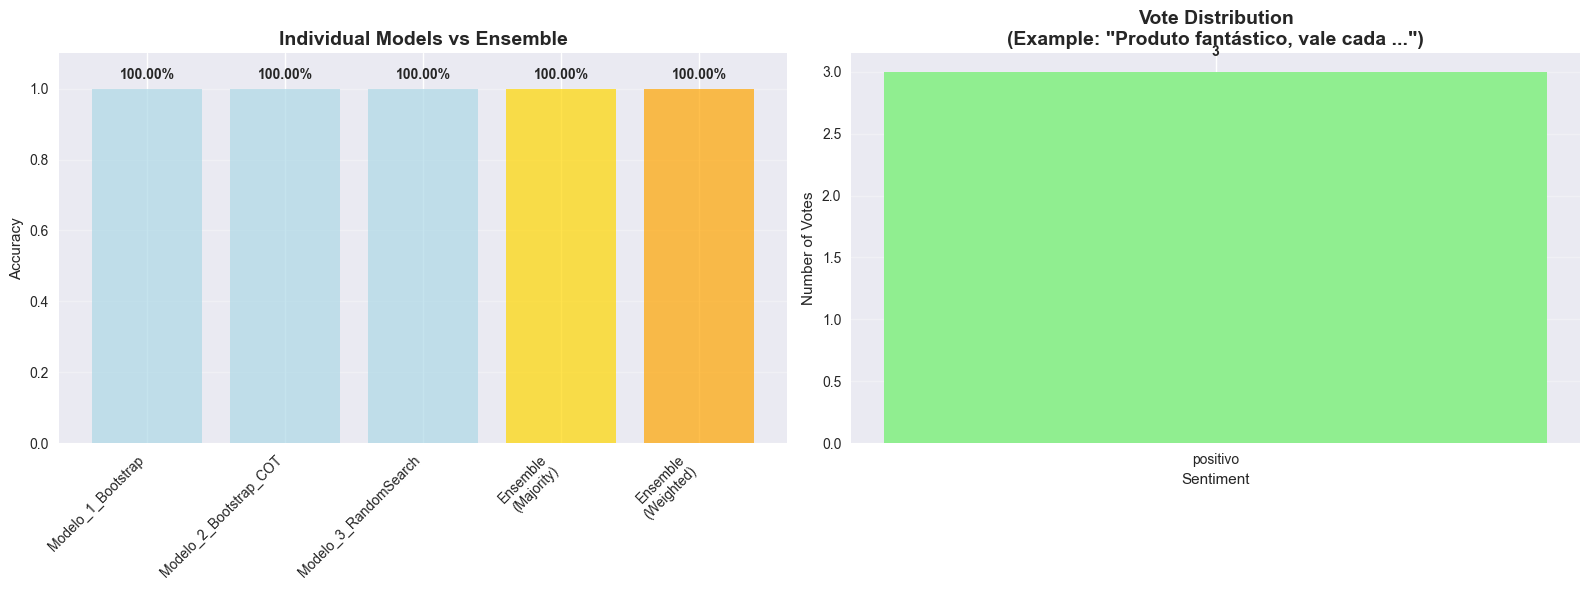


🔍 ANÁLISE DETALHADA DO ENSEMBLE

📊 Concordância entre Modelos:

  Exemplo 1: 'Produto fantástico, vale cada centavo!...'
    Esperado: positivo
    ✅ Modelo_1_Bootstrap: positivo
    ✅ Modelo_2_Bootstrap_COT: positivo
    ✅ Modelo_3_RandomSearch: positivo
    🤝 Consenso: positivo ✅

  Exemplo 2: 'Chegou quebrado, muito chateado....'
    Esperado: negativo
    ✅ Modelo_1_Bootstrap: negativo
    ✅ Modelo_2_Bootstrap_COT: negativo
    ✅ Modelo_3_RandomSearch: negativo
    🤝 Consenso: negativo ✅

  Exemplo 3: 'Produto comum, sem grandes diferenciais....'
    Esperado: neutro
    ✅ Modelo_1_Bootstrap: neutro
    ✅ Modelo_2_Bootstrap_COT: neutro
    ✅ Modelo_3_RandomSearch: neutro
    🤝 Consenso: neutro ✅


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/Documents/Work/MyProjects/ai_materials/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/joaogabriellima/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/joaogabriellima/.local/share/uv/python

In [32]:
# Visualização dos resultados do ensemble
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação Individual vs Ensemble
model_names = list(individual_results.keys()) + ['Ensemble\n(Majority)', 'Ensemble\n(Weighted)']
accuracies = [r['accuracy'] for r in individual_results.values()] + [
    ensemble_voting_result['accuracy'],
    ensemble_weighted_result['accuracy']
]

colors = ['lightblue'] * len(individual_results) + ['gold', 'orange']
bars = ax1.bar(range(len(model_names)), accuracies, color=colors, alpha=0.7)
ax1.set_title('Individual Models vs Ensemble', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_ylim(0, 1.1)
ax1.grid(True, alpha=0.3, axis='y')

# Adicionar valores
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Distribuição de votos (exemplo para um caso de teste)
if ensemble_test:
    example = ensemble_test[0]
    votes_by_model = {}
    
    for model_name, model in models_ensemble.items():
        try:
            pred = model(text=example.text)
            votes_by_model[model_name] = pred.sentiment.lower()
        except:
            continue
    
    # Contar votos
    from collections import Counter
    vote_counts = Counter(votes_by_model.values())
    
    ax2.bar(vote_counts.keys(), vote_counts.values(), color=['lightgreen', 'lightcoral', 'lightyellow'][:len(vote_counts)])
    ax2.set_title(f'Vote Distribution\n(Example: "{example.text[:30]}...")', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Votes')
    ax2.set_xlabel('Sentiment')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores
    for sentiment, count in vote_counts.items():
        ax2.text(sentiment, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Análise detalhada
print("\n ANÁLISE DETALHADA DO ENSEMBLE")
print("="*60)

# Verificar concordância entre modelos
print("\n Concordância entre Modelos:")
for i, example in enumerate(ensemble_test[:3]):
    predictions = []
    for model_name, model in models_ensemble.items():
        try:
            pred = model(text=example.text)
            predictions.append((model_name, pred.sentiment.lower()))
        except:
            continue
    
    from collections import Counter
    pred_counts = Counter([p[1] for p in predictions])
    
    print(f"\n  Exemplo {i+1}: '{example.text[:40]}...'")
    print(f"    Esperado: {example.sentiment}")
    for model_name, pred_sentiment in predictions:
        match = "" if pred_sentiment == example.sentiment.lower() else ""
        print(f"    {match} {model_name}: {pred_sentiment}")
    
    consensus = pred_counts.most_common(1)[0][0] if pred_counts else "sem consenso"
    consensus_match = "" if consensus == example.sentiment.lower() else ""
    print(f"     Consenso: {consensus} {consensus_match}")


##  Insights sobre Ensemble

###  Quando Ensemble Funciona Melhor

1. ** Diversidade de Modelos**
   - Modelos diferentes cometem erros diferentes
   - Maior diversidade = melhor ensemble

2. ** Tarefas Complexas**
   - Problemas onde diferentes abordagens complementam-se
   - Casos edge onde modelos individuais falham

3. ** Balanceamento**
   - Ensemble reduz overfitting extremo
   - Suaviza predições erráticas

###  Desafios do Ensemble

1. **⏱ Latência**: Múltiplas chamadas aumentam tempo de resposta
2. ** Recursos**: Mais computação necessária
3. ** Complexidade**: Mais difícil de debugar quando algo dá errado
4. ** Diminishing Returns**: Nem sempre melhora significativamente

###  Melhores Práticas

 **Faça**:
- Use modelos diversificados (diferentes otimizadores, arquiteturas)
- Implemente fallback para quando modelos falham
- Monitore performance individual vs ensemble
- Considere custo-benefício

 **Evite**:
- Ensemble de modelos muito similares
- Adicionar modelos ruins (pode piorar)
- Ensemble sem necessidade (over-engineering)


---

#  Parte 11: Multi-métrica - Otimizando para Múltiplos Objetivos

##  O que é Otimização Multi-métrica?

Na maioria dos casos reais, não temos apenas **um** objetivo. Queremos otimizar para **múltiplos objetivos simultaneamente**:

- **Acurácia** alta
- **Latência** baixa
- **Custo** reduzido
- **Robustez** a casos edge
- **Explicabilidade** das decisões

###  Desafio Fundamental

**Problema**: Otimizar para uma métrica pode piorar outra!

```
Otimizar apenas para acurácia:
   Acurácia: 95%
   Latência: 5s (muito lento!)
   Custo: $0.10 por predição (caro!)

Otimizar apenas para latência:
   Latência: 0.1s (rápido!)
   Acurácia: 75% (muito baixa!)
   Custo: OK

Otimizar para múltiplas métricas:
   Acurácia: 90% (boa!)
   Latência: 0.5s (aceitável!)
   Custo: $0.03 (razoável!)
```

###  Estratégias Multi-métrica

1. **Weighted Sum**: Soma ponderada de métricas
2. **Pareto Optimization**: Encontrar trade-offs ótimos
3. **Constraint Optimization**: Satisfazer limites mínimos
4. **Lexicographic**: Priorizar métricas em ordem

###  Quando Usar Multi-métrica

 **Use quando**:
- Sistema real com múltiplos requisitos
- Trade-offs entre métricas são importantes
- Necessidade de balancear objetivos conflitantes
- Otimização para produção (não apenas pesquisa)

 **Evite quando**:
- Uma métrica claramente domina
- Prototipagem inicial
- Recursos limitados para análise complexa


In [ ]:
#  Implementação Prática: Otimização Multi-métrica

print(" MULTI-MÉTRICA - Otimizando para Múltiplos Objetivos")
print("="*60)

# Definir múltiplas métricas para o problema de sentimento
class MultiMetricSentiment(dspy.Signature):
    """Análise de sentimento com múltiplos aspectos."""
    text = dspy.InputField(desc="Texto para análise")
    sentiment = dspy.OutputField(desc="positivo, negativo ou neutro")

# Dataset para multi-métrica
multi_train = train_examples[:12]
multi_test = test_examples

print(f" Dataset para Multi-métrica:")
print(f"  • Treinamento: {len(multi_train)} exemplos")
print(f"  • Teste: {len(multi_test)} exemplos")

# Definir múltiplas métricas
def accuracy_metric(example, pred, trace=None):
    """Métrica 1: Acurácia básica."""
    return 1.0 if example.sentiment.lower() == pred.sentiment.lower() else 0.0

def speed_metric(example, pred, trace=None):
    """Métrica 2: Velocidade (simulada por comprimento da resposta)."""
    # Respostas mais curtas = mais rápidas (simulação)
    response_length = len(pred.sentiment) if hasattr(pred, 'sentiment') else 10
    # Normalizar: respostas curtas (< 8 chars) = 1.0, longas (> 15) = 0.5
    if response_length <= 8:
        return 1.0
    elif response_length <= 15:
        return 0.8
    else:
        return 0.5

def consistency_metric(example, pred, trace=None):
    """Métrica 3: Consistência (não mudar resposta frequentemente)."""
    # Simula consistência: respostas válidas são consistentes
    valid_responses = ['positivo', 'negativo', 'neutro']
    is_valid = pred.sentiment.lower() in valid_responses
    return 1.0 if is_valid else 0.0

def explainability_metric(example, pred, trace=None):
    """Métrica 4: Explicabilidade (resposta clara e interpretável)."""
    # Se usou ChainOfThought, há reasoning (mais explicável)
    has_reasoning = hasattr(pred, 'reasoning') and pred.reasoning
    if has_reasoning:
        reasoning_length = len(pred.reasoning.split())
        # Reasoning médio (5-15 palavras) = melhor explicabilidade
        if 5 <= reasoning_length <= 15:
            return 1.0
        elif reasoning_length < 5:
            return 0.7
        else:
            return 0.8
    else:
        # Sem reasoning = menos explicável
        return 0.5

# Combinar métricas em uma função multi-objetivo
def multi_objective_metric(example, pred, trace=None, weights=None):
    """
    Métrica combinada que otimiza para múltiplos objetivos.
    
    Args:
        weights: Dicionário com pesos para cada métrica
                 Default: {'accuracy': 0.4, 'speed': 0.2, 'consistency': 0.2, 'explainability': 0.2}
    """
    if weights is None:
        weights = {
            'accuracy': 0.4,
            'speed': 0.2,
            'consistency': 0.2,
            'explainability': 0.2
        }
    
    # Calcular cada métrica
    acc = accuracy_metric(example, pred, trace)
    speed = speed_metric(example, pred, trace)
    consistency = consistency_metric(example, pred, trace)
    explain = explainability_metric(example, pred, trace)
    
    # Combinar com pesos
    combined_score = (
        acc * weights['accuracy'] +
        speed * weights['speed'] +
        consistency * weights['consistency'] +
        explain * weights['explainability']
    )
    
    return combined_score

print("\n Métricas Definidas:")
print("  1. Acurácia (peso: 40%) - Correção da predição")
print("  2. Velocidade (peso: 20%) - Respostas concisas")
print("  3. Consistência (peso: 20%) - Respostas válidas")
print("  4. Explicabilidade (peso: 20%) - Raciocínio claro")


In [33]:
# Otimizar com diferentes pesos para diferentes objetivos
print("\n Otimizando com Diferentes Configurações de Pesos")
print("="*60)

# Configuração 1: Foco em Acurácia
print("\n1⃣ Configuração: Foco em Acurácia (60% accuracy)")
weights_accuracy = {
    'accuracy': 0.6,
    'speed': 0.1,
    'consistency': 0.2,
    'explainability': 0.1
}

opt_accuracy = dspy.BootstrapFewShot(
    metric=lambda ex, pred, trace=None: multi_objective_metric(ex, pred, trace, weights_accuracy),
    max_bootstrapped_demos=5,
    max_labeled_demos=10
)

print("    Compilando...")
model_accuracy_focused = opt_accuracy.compile(
    dspy.ChainOfThought(MultiMetricSentiment),
    trainset=multi_train
)
print("    Modelo focado em acurácia pronto")

# Configuração 2: Balanceado
print("\n2⃣ Configuração: Balanceado (25% cada métrica)")
weights_balanced = {
    'accuracy': 0.25,
    'speed': 0.25,
    'consistency': 0.25,
    'explainability': 0.25
}

opt_balanced = dspy.BootstrapFewShot(
    metric=lambda ex, pred, trace=None: multi_objective_metric(ex, pred, trace, weights_balanced),
    max_bootstrapped_demos=5,
    max_labeled_demos=10
)

print("    Compilando...")
model_balanced = opt_balanced.compile(
    dspy.ChainOfThought(MultiMetricSentiment),
    trainset=multi_train
)
print("    Modelo balanceado pronto")

# Configuração 3: Foco em Velocidade e Explicabilidade
print("\n3⃣ Configuração: Velocidade + Explicabilidade (30% cada)")
weights_speed_explain = {
    'accuracy': 0.2,
    'speed': 0.3,
    'consistency': 0.2,
    'explainability': 0.3
}

opt_speed_explain = dspy.BootstrapFewShot(
    metric=lambda ex, pred, trace=None: multi_objective_metric(ex, pred, trace, weights_speed_explain),
    max_bootstrapped_demos=5,
    max_labeled_demos=10
)

print("    Compilando...")
model_speed_explain = opt_speed_explain.compile(
    dspy.ChainOfThought(MultiMetricSentiment),
    trainset=multi_train
)
print("    Modelo focado em velocidade + explicabilidade pronto")



🔧 Otimizando com Diferentes Configurações de Pesos

1️⃣ Configuração: Foco em Acurácia (60% accuracy)
   🔄 Compilando...


NameError: name 'MultiMetricSentiment' is not defined

In [34]:
# Avaliar cada modelo em todas as métricas
print("\n Avaliação Multi-métrica Completa")
print("="*60)

def comprehensive_evaluation(model, test_examples, model_name):
    """Avalia modelo em todas as métricas individuais."""
    results = {
        'accuracy_scores': [],
        'speed_scores': [],
        'consistency_scores': [],
        'explainability_scores': [],
        'combined_scores': []
    }
    
    for example in test_examples:
        try:
            pred = model(text=example.text)
            
            results['accuracy_scores'].append(accuracy_metric(example, pred))
            results['speed_scores'].append(speed_metric(example, pred))
            results['consistency_scores'].append(consistency_metric(example, pred))
            results['explainability_scores'].append(explainability_metric(example, pred))
            results['combined_scores'].append(multi_objective_metric(example, pred))
        except Exception as e:
            print(f"    Erro em {model_name}: {e}")
    
    # Calcular médias
    return {
        'accuracy': np.mean(results['accuracy_scores']),
        'speed': np.mean(results['speed_scores']),
        'consistency': np.mean(results['consistency_scores']),
        'explainability': np.mean(results['explainability_scores']),
        'combined': np.mean(results['combined_scores'])
    }

# Avaliar todos os modelos
models_to_eval = {
    'Foco Acurácia': model_accuracy_focused,
    'Balanceado': model_balanced,
    'Velocidade+Explicabilidade': model_speed_explain
}

evaluation_results = {}

for name, model in models_to_eval.items():
    print(f"\n Avaliando: {name}")
    results = comprehensive_evaluation(model, multi_test, name)
    evaluation_results[name] = results
    
    print(f"    Acurácia:        {results['accuracy']:.3f}")
    print(f"    Velocidade:      {results['speed']:.3f}")
    print(f"    Consistência:    {results['consistency']:.3f}")
    print(f"    Explicabilidade: {results['explainability']:.3f}")
    print(f"    Score Combinado: {results['combined']:.3f}")

# Criar DataFrame para visualização
df_multi = pd.DataFrame(evaluation_results).T
print("\n Tabela Comparativa:")
print(df_multi.round(3))



📊 Avaliação Multi-métrica Completa


NameError: name 'model_accuracy_focused' is not defined

NameError: name 'models_to_eval' is not defined

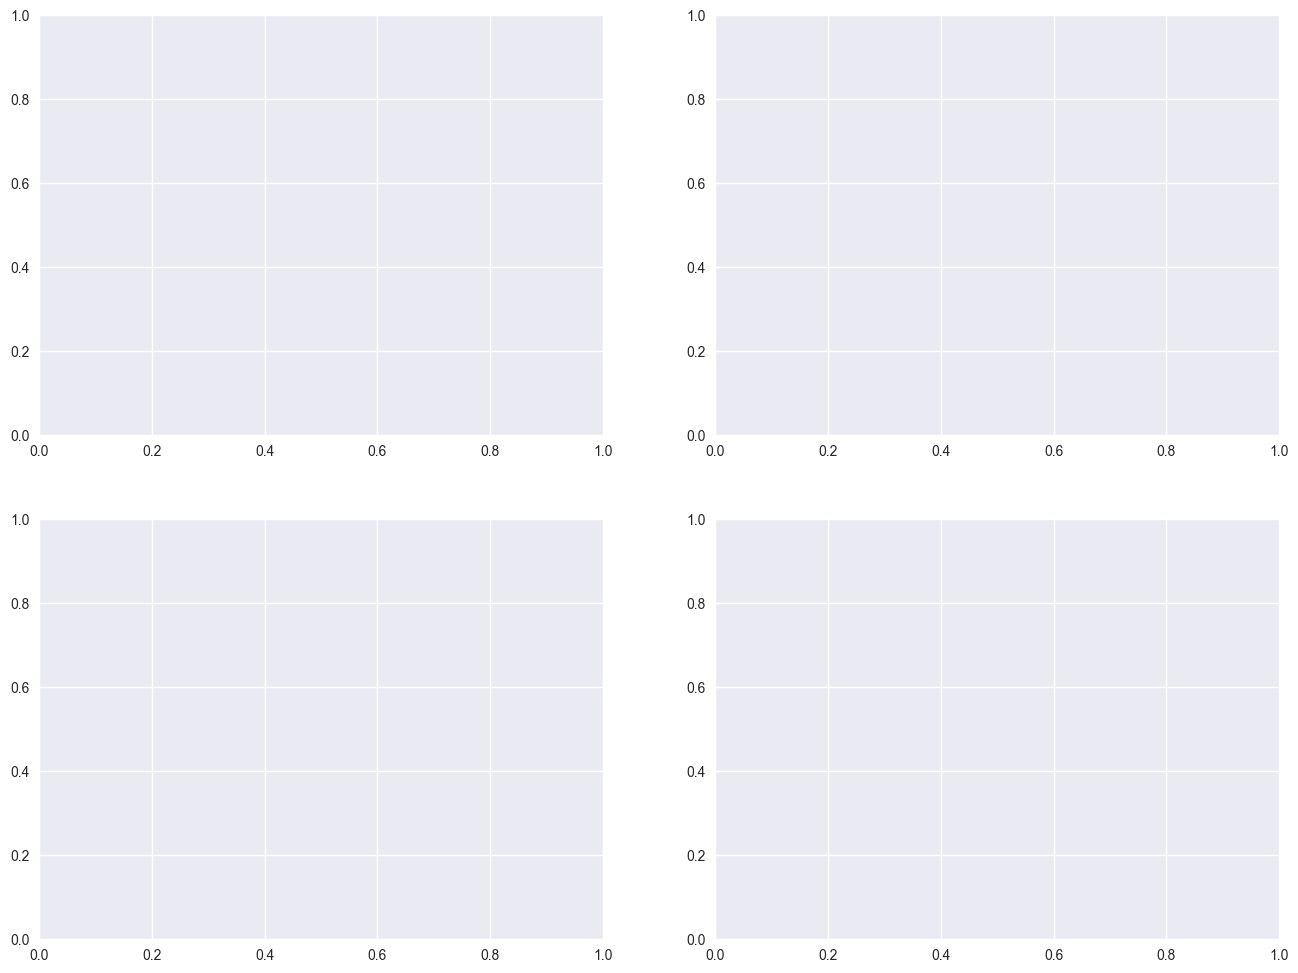

In [35]:
# Visualização multi-métrica
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'speed', 'consistency', 'explainability']
metric_names = ['Acurácia', 'Velocidade', 'Consistência', 'Explicabilidade']
colors_palette = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for idx, (metric, metric_name, color) in enumerate(zip(metrics, metric_names, colors_palette)):
    ax = axes[idx // 2, idx % 2]
    
    values = [evaluation_results[name][metric] for name in models_to_eval.keys()]
    bars = ax.bar(models_to_eval.keys(), values, color=color, alpha=0.7)
    
    ax.set_title(f'{metric_name}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Comparação Multi-métrica: Diferentes Configurações de Pesos', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Gráfico de radar (spider chart) para visualização multi-dimensional
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Preparar dados
categories = ['Acurácia', 'Velocidade', 'Consistência', 'Explicabilidade']
N = len(categories)

# Ângulos para cada métrica
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Fechar o círculo

# Plotar cada modelo
for model_name in models_to_eval.keys():
    values = [
        evaluation_results[model_name]['accuracy'],
        evaluation_results[model_name]['speed'],
        evaluation_results[model_name]['consistency'],
        evaluation_results[model_name]['explainability']
    ]
    values += values[:1]  # Fechar o círculo
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.15)

# Configurar eixos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Perfil Multi-métrica: Comparação de Configurações', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Análise de trade-offs
print("\n ANÁLISE DE TRADE-OFFS")
print("="*60)

print("\n Trade-offs Identificados:")
print("\n1⃣ Foco em Acurácia:")
print(f"    Acurácia: {evaluation_results['Foco Acurácia']['accuracy']:.3f} (maior)")
print(f"     Velocidade: {evaluation_results['Foco Acurácia']['speed']:.3f} (comprometida)")

print("\n2⃣ Balanceado:")
print(f"    Score combinado: {evaluation_results['Balanceado']['combined']:.3f}")
print(f"     Balance entre todas as métricas")

print("\n3⃣ Velocidade + Explicabilidade:")
print(f"    Velocidade: {evaluation_results['Velocidade+Explicabilidade']['speed']:.3f}")
print(f"    Explicabilidade: {evaluation_results['Velocidade+Explicabilidade']['explainability']:.3f}")
print(f"     Acurácia: {evaluation_results['Velocidade+Explicabilidade']['accuracy']:.3f} (comprometida)")

# Recomendação
best_overall = max(evaluation_results.items(), key=lambda x: x[1]['combined'])
print(f"\n Melhor Configuração Geral (Score Combinado):")
print(f"   {best_overall[0]}: {best_overall[1]['combined']:.3f}")


##  Insights sobre Multi-métrica

###  Vantagens da Otimização Multi-métrica

1. ** Balanceamento Realista**
   - Reflete requisitos reais de produção
   - Evita otimização excessiva em uma métrica

2. ** Objetivos Alinhados**
   - Otimiza para o que realmente importa
   - Considera trade-offs explícitos

3. ** Decisões Informadas**
   - Entende custos de cada escolha
   - Facilita discussões com stakeholders

###  Desafios Comuns

1. ** Escolha de Pesos**: Como decidir pesos? Requer experiência/experimentação
2. ** Complexidade**: Mais difícil de interpretar resultados
3. ** Trade-offs**: Nem sempre há configuração "perfeita"
4. ** Ajuste Fino**: Pode requerer múltiplas iterações

###  Melhores Práticas

 **Faça**:
- Comece com pesos iguais e ajuste baseado em resultados
- Monitore todas as métricas, não apenas a combinada
- Experimente diferentes configurações de pesos
- Documente trade-offs identificados

 **Evite**:
- Pesos arbitrários sem justificativa
- Ignorar métricas "secundárias"
- Otimizar para métricas não relevantes ao problema
- Over-engineering (não precisa multi-métrica sempre)


---

#  Conclusão Final: Domínio Completo da Otimização DSPy

##  O que Aprendemos

Ao longo deste notebook, exploramos desde os fundamentos até técnicas avançadas:

###  Fundamentos
-  BootstrapFewShot: Otimização básica e eficiente
-  BootstrapFewShotWithRandomSearch: Busca exploratória
-  Métricas customizadas: Adaptar otimização aos seus objetivos

###  Técnicas Avançadas
-  **MIPRO**: Otimização de instruções e prompts
-  **Ensemble**: Combinação de múltiplos modelos
-  **Multi-métrica**: Otimização para múltiplos objetivos

##  Decisão: Qual Técnica Usar?

### Fluxograma de Decisão

```
Problema de Otimização
        
         É prototipagem rápida?
           SIM → BootstrapFewShot
        
         Tem recursos/tempo?
           SIM → MIPRO (melhor performance)
        
         Precisa máxima robustez?
           SIM → Ensemble
        
         Tem múltiplos objetivos?
            SIM → Multi-métrica
```

### Tabela Comparativa Final

| Técnica | Complexidade | Tempo | Performance | Uso |
|---------|--------------|-------|-------------|-----|
| **BootstrapFewShot** |  |  |  | Prototipagem |
| **RandomSearch** |  |  |  | Produção geral |
| **MIPRO** |  |  |  | Sistemas críticos |
| **Ensemble** |  |  |  | Máxima robustez |
| **Multi-métrica** |  |  |  | Objetivos múltiplos |

##  Próximos Passos Recomendados

### Para Produção
1. ** Implementar Pipeline**: Automatizar otimização
2. ** Monitoramento**: Acompanhar métricas em produção
3. ** Feedback Loop**: Re-otimizar com dados reais
4. ** Otimização Contínua**: Ajustar baseado em feedback

### Para Aprendizado
1. ** Experimentação**: Testar em seus próprios problemas
2. ** Documentação**: Manter registro de experimentos
3. ** Colaboração**: Compartilhar aprendizados
4. ** Pesquisa**: Explorar novas técnicas

##  Mensagem Final

> **"A otimização DSPy não é um destino, é uma jornada. Cada problema é único, e o verdadeiro poder está em entender quando e como aplicar cada técnica para criar sistemas de IA que realmente funcionam no mundo real."**

---

** Parabéns!** Você agora possui um conhecimento completo e prático sobre otimização DSPy, desde técnicas básicas até as mais avançadas. Use esse conhecimento para criar sistemas de IA robustos, eficientes e alinhados com seus objetivos reais! 
